In [1]:
import matplotlib.pyplot as plt
import torch
import os
from pathlib import Path
from importlib import reload

os.chdir("..")  # Change root dir to project folder
os.getcwd()

'/home/bbd0953/diffusion/src'

# PyBDSF Segmentation

In [2]:
import utils.paths as paths
import data.datasets

reload(data.datasets)
from data.datasets import LOFARDataset

import data.segment as seg

reload(seg)

# Load Dataset
dset = LOFARDataset(
    paths.LOFAR_SUBSETS["200p"], img_size=200, load_catalog=True,
    train_mode=False,
    # selection='clean_mask_single_island'
)

INFO (data.datasets): Loading images...
INFO (data.datasets): Loading names from catalog...
INFO (data.datasets): Loading 'island_labels'...
INFO (data.datasets): Loading 'masks_edge_thr'...
INFO (data.datasets): Loading 'masks_refined'...
INFO (data.datasets): Loading catalog and entries...
INFO (data.datasets): Data set initialized.


In [3]:
import data.transforms as T

reload(T)
import numpy as np
import numpy.ma as ma

dset.masks = dset.masks_refined

# Get data from dset
imgs = dset.data.numpy()
imgs_sc = T.max_scale_batch(dset.data).numpy()
masks = dset.masks.numpy()
source_signals_sc = imgs_sc * masks

# Apply masks (True indicates invalid data)
sources_sc = ma.masked_array(imgs_sc, mask=(masks == 0))
backgrounds_sc = ma.masked_array(imgs_sc, mask=(masks == 1))

## Mask Post-Processing

Test Smoothing & Refinement with random subset:

In [ ]:
import numpy as np
from tqdm import tqdm
import data.transforms

reload(data.transforms)
from data.transforms import minmax_scale_batch
import os

reload(seg)

idx = np.random.choice(len(dset), 1_000, replace=False)
imgs = minmax_scale_batch(dset.data[idx]).numpy()

masks = seg.smooth_masks_parallel(dset.island_labels[idx])
ref_masks = seg.refine_masks_iterative_parallel(imgs, masks)

In [ ]:
from plotting.image_plots import plot_image_grid

n = 10
ii = np.random.choice(len(idx), n, replace=False)

for i in ii:
    # Plot image with three masks: original, smoothed, refined
    img = imgs[i].squeeze()
    fig, axs = plt.subplots(3, 3, figsize=(12,)*2, tight_layout=True)

    for ax in axs.flatten():
        ax.axis('off')

    for aa in axs.T:
        aa[0].imshow(img)

    for i, mask in enumerate([dset.island_labels[idx[i]].numpy().astype(bool), masks[i], ref_masks[i]]):
        axs[0][i].contour(mask, levels=[0.5], colors='orange', linewidths=0.5, alpha=0.9)
        axs[1][i].imshow(img * mask)
        axs[2][i].imshow(img * (1 - mask))

    axs[0][0].set_title('PyBDSF Islands')
    axs[0][1].set_title('Smoothed Mask')
    axs[0][2].set_title('Refined Mask')

In [ ]:
from plotting.image_plots import plot_image_grid

n = 10
ii = np.random.choice(len(idx), n, replace=False)

for i in ii:
    # Plot image with three masks: original, smoothed, refined
    img = imgs[i].squeeze()
    mask = ref_masks[i]

    fig, axs = plt.subplots(1, 3, figsize=(12,)*2, tight_layout=True)

    axs[0].imshow(img)
    axs[0].contour(mask, levels=[0.5], colors='orange', linewidths=0.5, alpha=0.9)
    axs[1].imshow(img * mask)
    axs[2].imshow(img * (1 - mask))

    for ax in axs:
        ax.axis('off')

    fig.show()


Look at background statistics:

In [ ]:
backgrounds = imgs * (1 - ref_masks)

fig, axs = plt.subplots(1, 3, figsize=(16, 6), tight_layout=True)

bin_max = 0.3
bin_width = 0.01
bins = np.arange(0, bin_max, bin_width)
axs[0].hist(backgrounds.flatten(), bins=bins, label="Background Pixels", density=True)
# axs[0].set_yscale('log')
axs[1].hist(backgrounds.mean(axis=(1, 2)), bins=50, label="Mean Background")
axs[2].hist(backgrounds.std(axis=(1, 2)), bins=50, label="Std. Background")

for ax in axs:
    ax.legend()
    ax.grid(alpha=0.3)

fig.show()

In [ ]:
# Cumulative distribution for background pixels, mean and std
fig, axs = plt.subplots(1, 3, figsize=(16, 6), tight_layout=True)

# Pixels
bg = backgrounds.flatten()
axs[0].hist(bg, bins=500, density=True, cumulative=True, histtype="step")
axs[0].set_xlabel("Background Pixels")
axs[0].set_ylabel("Cumulative Probability")

# Mean
mean_bg = backgrounds.mean(axis=(1, 2))
mean_bg = np.sort(mean_bg)
n = len(mean_bg)
axs[1].plot(mean_bg, np.linspace(0, 1, n))
axs[1].set_xlabel("Mean Background")

# Std
std_bg = backgrounds.std(axis=(1, 2))
std_bg = np.sort(std_bg)
n = len(std_bg)
axs[2].plot(std_bg, np.linspace(0, 1, n))
axs[2].set_xlabel("Std. Background")

for ax in axs:
    ax.grid(alpha=0.3)

fig.show()

In [ ]:
from plotting.image_plots import metric_peek

metric_peek(
    backgrounds.mean(axis=(1, 2)),
    np.linspace(0, 0.1, 6),
    imgs,
    metric_name="Mean Background",
)

In [ ]:
bg_threshold = 0.02
low_bg_idxs = np.nonzero(backgrounds.mean(axis=(1, 2)) < bg_threshold)[0]

ii = np.random.choice(low_bg_idxs, 5, replace=False)

for i in ii:
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), tight_layout=True)

    axs[0].imshow(imgs[i])
    axs[0].contour(ref_masks[i], colors="lime", linewidths=0.3, alpha=0.7, levels=[0.5])
    axs[1].imshow(imgs[i] * ref_masks[i])
    axs[2].imshow(imgs[i] * (1 - ref_masks[i]))

    for ax in axs:
        ax.axis("off")

    fig.show()

In [ ]:
from scipy.optimize import curve_fit


def gaussian(x, s):
    return 1 / (np.sqrt(2 * np.pi) * s) * np.exp(-(x**2) / (2 * np.pi * s**2))


ii = np.random.choice(low_bg_idxs, 5, replace=False)

for i in ii:
    original_image = original_imgs[i].numpy()
    mask = ref_masks[i]

    fig, axs = plt.subplots(2, 2, figsize=(12, 12), tight_layout=True)

    ax = axs[0][0]
    bins = np.linspace(-1e-3, 1e-3, 100)

    c, _, _ = ax.hist(
        original_image.flatten(), bins=bins, label="Full Image", histtype="step"
    )
    a0 = c.max()
    bg_pixels = original_image[mask == 0].flatten()
    ax.hist(bg_pixels, bins=bins, label="Bg. Pixels", histtype="step")

    # Fit a gaussian with zero mean and free variance and amplitude
    y, x = np.histogram(original_image.flatten(), bins=bins, density=True)
    x = (x[1:] + x[:-1]) / 2
    x, y = x[25:-25], y[25:-25]
    popt, pcov = curve_fit(gaussian, x, y, p0=[1e-5])

    s = popt[0]
    ax.plot(
        x, np.sqrt(2 * np.pi) * s / a0 * gaussian(x, *popt), label=f"Fit: s={s:.2e}"
    )
    # Vertical lines at s, 2s, 3s, 5s with annotations on top
    for mult in [1, 2, 3, 5]:
        ax.axvline(s * mult, color="r", linestyle="--", linewidth=0.5)
        ax.text(
            s * mult, 0.9 * ax.get_ylim()[1], f"{mult}σ", color="r", fontsize="small"
        )

    ax = axs[0][1]
    c, b, _ = ax.hist(
        original_image.flatten(), bins=100, label="Full Image", histtype="step"
    )
    masked_pixels = original_image[mask == 1].flatten()
    ax.hist(masked_pixels, bins=b, label="Masked Pixels", histtype="step")

    for ax in axs[0]:
        ax.legend()
        ax.set_yscale("log")
        ax.grid(alpha=0.3)

    ax = axs[1][0]
    ax.imshow(original_image)
    ax.contour(mask, colors="lime", linewidths=0.3, alpha=0.7, levels=[0.5])

    ax = axs[1][1]
    ax.imshow(original_image * (1 - mask))

    for ax in axs[1]:
        ax.axis("off")

    fig.show()

In [ ]:
# Cumulative distribution for background pixels, mean and std
fig, axs = plt.subplots(1, 3, figsize=(16, 6), tight_layout=True)

# Pixels
bg = backgrounds[low_bg_idxs].flatten()
axs[0].hist(bg, bins=500, density=True, cumulative=True, histtype="step")
axs[0].set_xlabel("Background Pixels")
axs[0].set_ylabel("Cumulative Probability")

# Mean
mean_bg = backgrounds[low_bg_idxs].mean(axis=(1, 2))
mean_bg = np.sort(mean_bg)
n = len(mean_bg)
axs[1].plot(mean_bg, np.linspace(0, 1, n))
axs[1].set_xlabel("Mean Background")

# Std
std_bg = backgrounds[low_bg_idxs].std(axis=(1, 2))
std_bg = np.sort(std_bg)
n = len(std_bg)
axs[2].plot(std_bg, np.linspace(0, 1, n))
axs[2].set_xlabel("Std. Background")

for ax in axs:
    ax.grid(alpha=0.3)

fig.suptitle("Selection: Bg. Mean < 0.02", fontsize="xx-large")

fig.show()

Plot images with ellipse etc.

In [ ]:
idx = idxs[2]

img = mask_subset[idx].squeeze().numpy()
bdsf_labels = mask_subset.island_labels[idx]
mask = seg.smooth_mask(bdsf_labels)
mask_dilated = ndimage.binary_dilation(mask, iterations=3)
mask_refined = np.zeros_like(mask, dtype=int)
labels = label(mask)

fig, axs = plt.subplots(2, 3, figsize=(18, 12), tight_layout=True)
axs[0][0].imshow(img)
axs[0][1].imshow(img)
axs[1][0].imshow(img)
axs[1][1].imshow(img)
axs[1][0].contour(mask_dilated, colors="lime", linewidths=0.3, alpha=0.7, levels=[0.5])
axs[0][2].imshow(img * mask)

for region in regionprops(labels):

    ax = axs[0][1]
    region_mask = labels == region.label
    ax.contour(region_mask, colors="cyan", linewidths=0.3, alpha=0.7, levels=[0.5])

    # Add cicrle
    x, y, r = sc.make_circle(region.coords)
    x, y, r = np.round(np.array([x, y, np.ceil(r)])).astype(int)
    ax.add_patch(plt.Circle((y, x), r, color="r", fill=False, linewidth=0.3, alpha=0.7))

    # Add centroid
    centroid = region.centroid
    ax.scatter(
        centroid[1], centroid[0], color="orange", marker="x", s=10, linewidths=0.5
    )

    # Add bounding box
    minr, minc, maxr, maxc = region.bbox
    rect = plt.Rectangle(
        (minc, minr),
        maxc - minc,
        maxr - minr,
        fill=False,
        color="lime",
        linewidth=0.3,
        alpha=1,
    )
    ax.add_patch(rect)

    # Add ellipse
    ell = Ellipse(
        tuple(reversed(region.centroid)),
        region.major_axis_length,
        region.minor_axis_length,
        angle=90 - region.orientation * 360 / (2 * np.pi),
        fill=False,
        color="magenta",
        linewidth=0.3,
        alpha=0.7,
    )
    ax.add_patch(ell)

    # Add scaled ellipse
    c = 3
    ell = Ellipse(
        tuple(reversed(region.centroid)),
        region.major_axis_length * 3,
        region.minor_axis_length * 3,
        angle=90 - region.orientation * 360 / (2 * np.pi),
        fill=False,
        color="yellow",
        linewidth=0.3,
        alpha=0.7,
    )
    ax.add_patch(ell)

    # Generate ellipse mask
    c = 1
    ell_mask = seg.elliptic_mask(
        region,
    )
    ax.contour(ell_mask, colors="fuchsia", linewidths=0.3, alpha=0.7, levels=[0.5])

    ax.set_xlim(0, img.shape[1])
    ax.set_ylim(img.shape[0], 0)

## Mask Edge Threshold

In [4]:
# Functions
from scipy import ndimage
from tqdm import tqdm
import numpy as np
import data.segment as seg

reload(seg)


# Number of islands in each image
def count_islands(masks):
    return np.array([ndimage.label(mask)[1] for mask in tqdm(masks)])


def relative_edge_max_island(mask, img):
    mx = (img * mask).max()
    edge = img * seg.mask_edge(mask) / mx
    return edge.max()


def scaled_edge_mean_std(mask, img):
    edge = img * seg.mask_edge(mask)
    return edge.mean(), edge.std()

def relative_edge_mean_std(mask, img):
    mx = (img * mask).max()
    edge = img * seg.mask_edge(mask) / mx
    return edge.mean(), edge.std()

def relative_edge_mean_std_img(mask, img):
    labels, n = ndimage.label(mask, structure=np.ones((3, 3)))
    return [
        relative_edge_mean_std((labels == lbl).astype(int), img)
        for lbl in range(1, n + 1)
    ]

def relative_edge_mean_std_imgs(masks, imgs):
    return [
        np.array(list(relative_edge_mean_std_img(mask, img)))
        for mask, img in zip(tqdm(masks), imgs)
    ]


def relative_edge_max_img(mask, img):
    labels, n = ndimage.label(mask, structure=np.ones((3, 3)))
    return [
        relative_edge_max_island((labels == lbl).astype(int), img)
        for lbl in range(1, n + 1)
    ]


def relative_edge_max_imgs(masks, imgs):
    return [
        np.array(list(relative_edge_max_img(mask, img)))
        for mask, img in zip(tqdm(masks), imgs)
    ]


def island_maxs_img(mask, img):
    labels, n = ndimage.label(mask, structure=np.ones((3, 3)))
    return np.array(
        [(img * (labels == lbl).astype(int)).max() for lbl in range(1, n + 1)]
    )


def island_maxs_imgs(masks, imgs):
    return [island_maxs_img(mask, img) for mask, img in zip(tqdm(masks), imgs)]

In [5]:
edge_mxs = relative_edge_max_imgs(masks, imgs)

  0%|          | 0/127559 [00:00<?, ?it/s]

100%|██████████| 127559/127559 [04:11<00:00, 506.98it/s]


### Look at some distributions

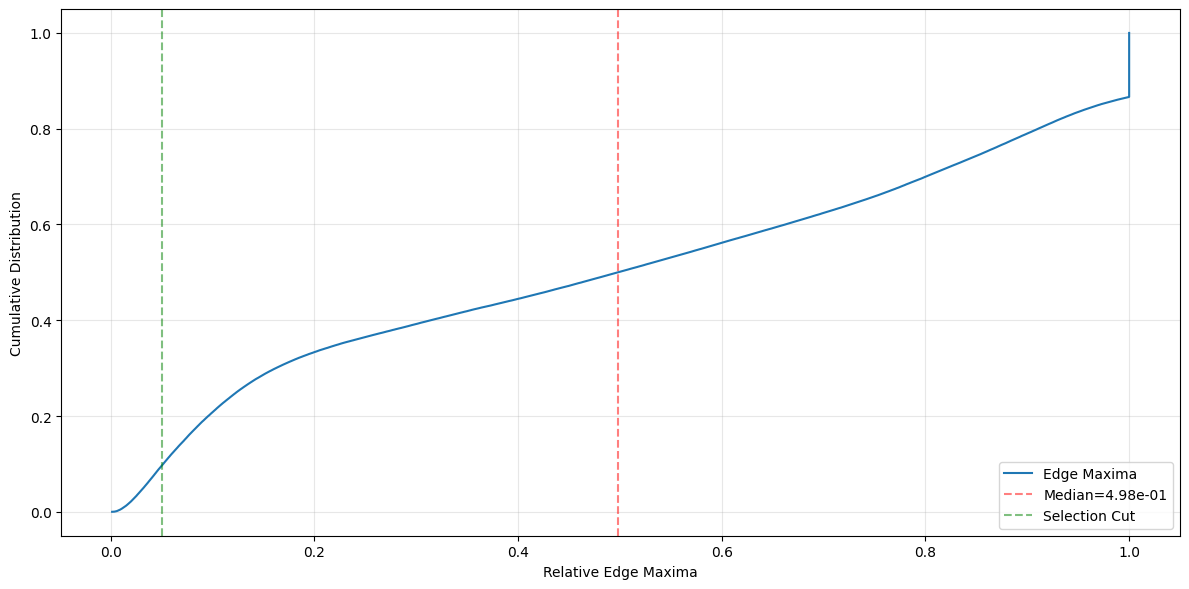

In [8]:
# Cumulative distribution of edge maxs.

edge_mxs_flat = np.concatenate(edge_mxs)
edge_mxs_flat_sorted = np.sort(edge_mxs_flat)

fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(12, 6))

ax.plot(
    edge_mxs_flat_sorted, np.linspace(0, 1, len(edge_mxs_flat)), label="Edge Maxima"
)
ax.axvline(
    md := np.median(edge_mxs_flat_sorted),
    color="r",
    label=f"Median={md:.2e}",
    alpha=0.5,
    ls="--",
)
ax.axvline(0.05, color="g", ls="--", alpha=0.5, label='Selection Cut')

ax.set_xlabel("Relative Edge Maxima")
ax.set_ylabel("Cumulative Distribution")

ax.grid(alpha=0.3)
ax.legend()
#ax.set_xlim(left=0, right=0.1)
#ax.set_ylim(top=0.2, bottom=-0.002)
# ax.set_xscale('log')


fig.show()

(-0.0005, 0.02)

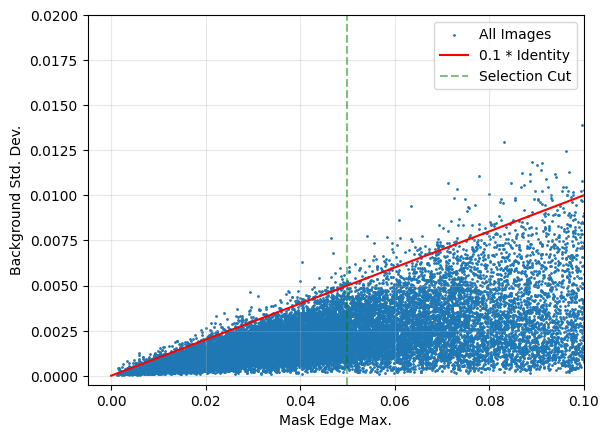

In [6]:
# Edge-max vs Background Std Scatter Plot
edge_mxmx = np.array([edge.max() for edge in edge_mxs])
bg_stds = np.std(backgrounds_sc, axis=(1, 2))

plt.scatter(edge_mxmx, bg_stds, s=1, label="All Images")
#plt.yscale('log')

# Plot identity
x = np.linspace(0, 0.1, 100)
plt.plot(x, 0.1 * x, color='r', label='0.1 * Identity')

plt.xlabel('Mask Edge Max.')
plt.ylabel('Background Std. Dev.')
plt.axvline(0.05, color='g', ls='--', alpha=0.5, label='Selection Cut')
plt.grid(alpha=0.3)
plt.legend()
plt.xlim(left=-0.005, right=0.1)
plt.ylim(bottom=-0.0005, top=0.02)

In [5]:
def single_islands_masks(masks):
    out_masks, out_idxs = [], []

    for i, mask in enumerate(tqdm(masks)):
        labels, n = ndimage.label(mask, structure=np.ones((3, 3)))
        for lbl in range(1, n + 1):
            out_masks.append((labels == lbl).astype(int))
            out_idxs.append(i)
    return np.array(out_masks), np.array(out_idxs)
    
single_masks, single_mask_idxs = single_islands_masks(masks)
single_mask_imgs = imgs[single_mask_idxs]

100%|██████████| 127559/127559 [01:01<00:00, 2074.73it/s]


In [6]:
edge_mx_single = relative_edge_max_imgs(single_masks, single_mask_imgs)
edge_mx_single = np.array(edge_mx_single)

100%|██████████| 463946/463946 [05:20<00:00, 1449.43it/s]


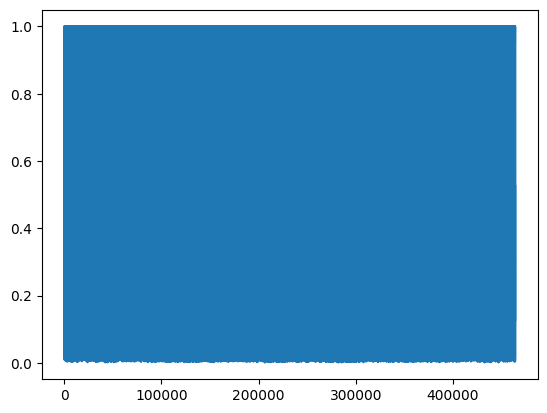

In [18]:
plt.hist(edge_mx_single)

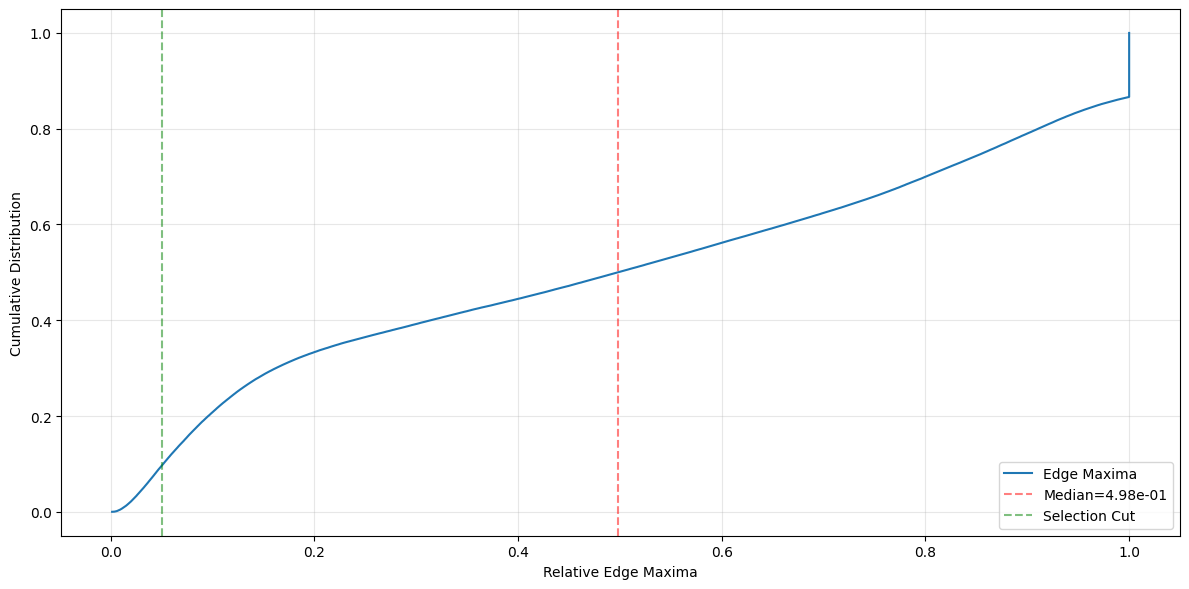

In [19]:
# Cumulative distribution of edge max single

idxs_mx_single_sorted = np.argsort(edge_mx_single.flatten())
edge_mx_single_sorted = edge_mx_single.flatten()[idxs_mx_single_sorted]

fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(12, 6))

ax.plot(
    edge_mx_single_sorted, np.linspace(0, 1, len(edge_mx_single_sorted)), label="Edge Maxima"
)
ax.axvline(
    md := np.median(edge_mx_single_sorted),
    color="r",
    label=f"Median={md:.2e}",
    alpha=0.5,
    ls="--",
)
ax.axvline(0.05, color="g", ls="--", alpha=0.5, label='Selection Cut')

ax.set_xlabel("Relative Edge Maxima")
ax.set_ylabel("Cumulative Distribution")

ax.grid(alpha=0.3)
ax.legend()
#ax.set_xlim(left=0, right=0.1)
#ax.set_ylim(top=0.2, bottom=-0.002)
# ax.set_xscale('log')


fig.show()

In [8]:
source_signals_single = [
    img * mask for img, mask in tqdm(zip(single_mask_imgs, single_masks), total=len(single_masks))
]

100%|██████████| 463946/463946 [00:32<00:00, 14150.15it/s]


In [10]:
# The list is too large and makes the kernel crash, so we will get a
# Random subsample
sub_idxs = np.random.choice(len(edge_mx_single), 10_000, replace=False)

edge_mx_single_sub = edge_mx_single[sub_idxs]
source_signals_single_sub = np.array(
    [source_signals_single[i] for i in tqdm(sub_idxs)]
)

100%|██████████| 10000/10000 [00:00<00:00, 1528536.44it/s]


Digitizing...


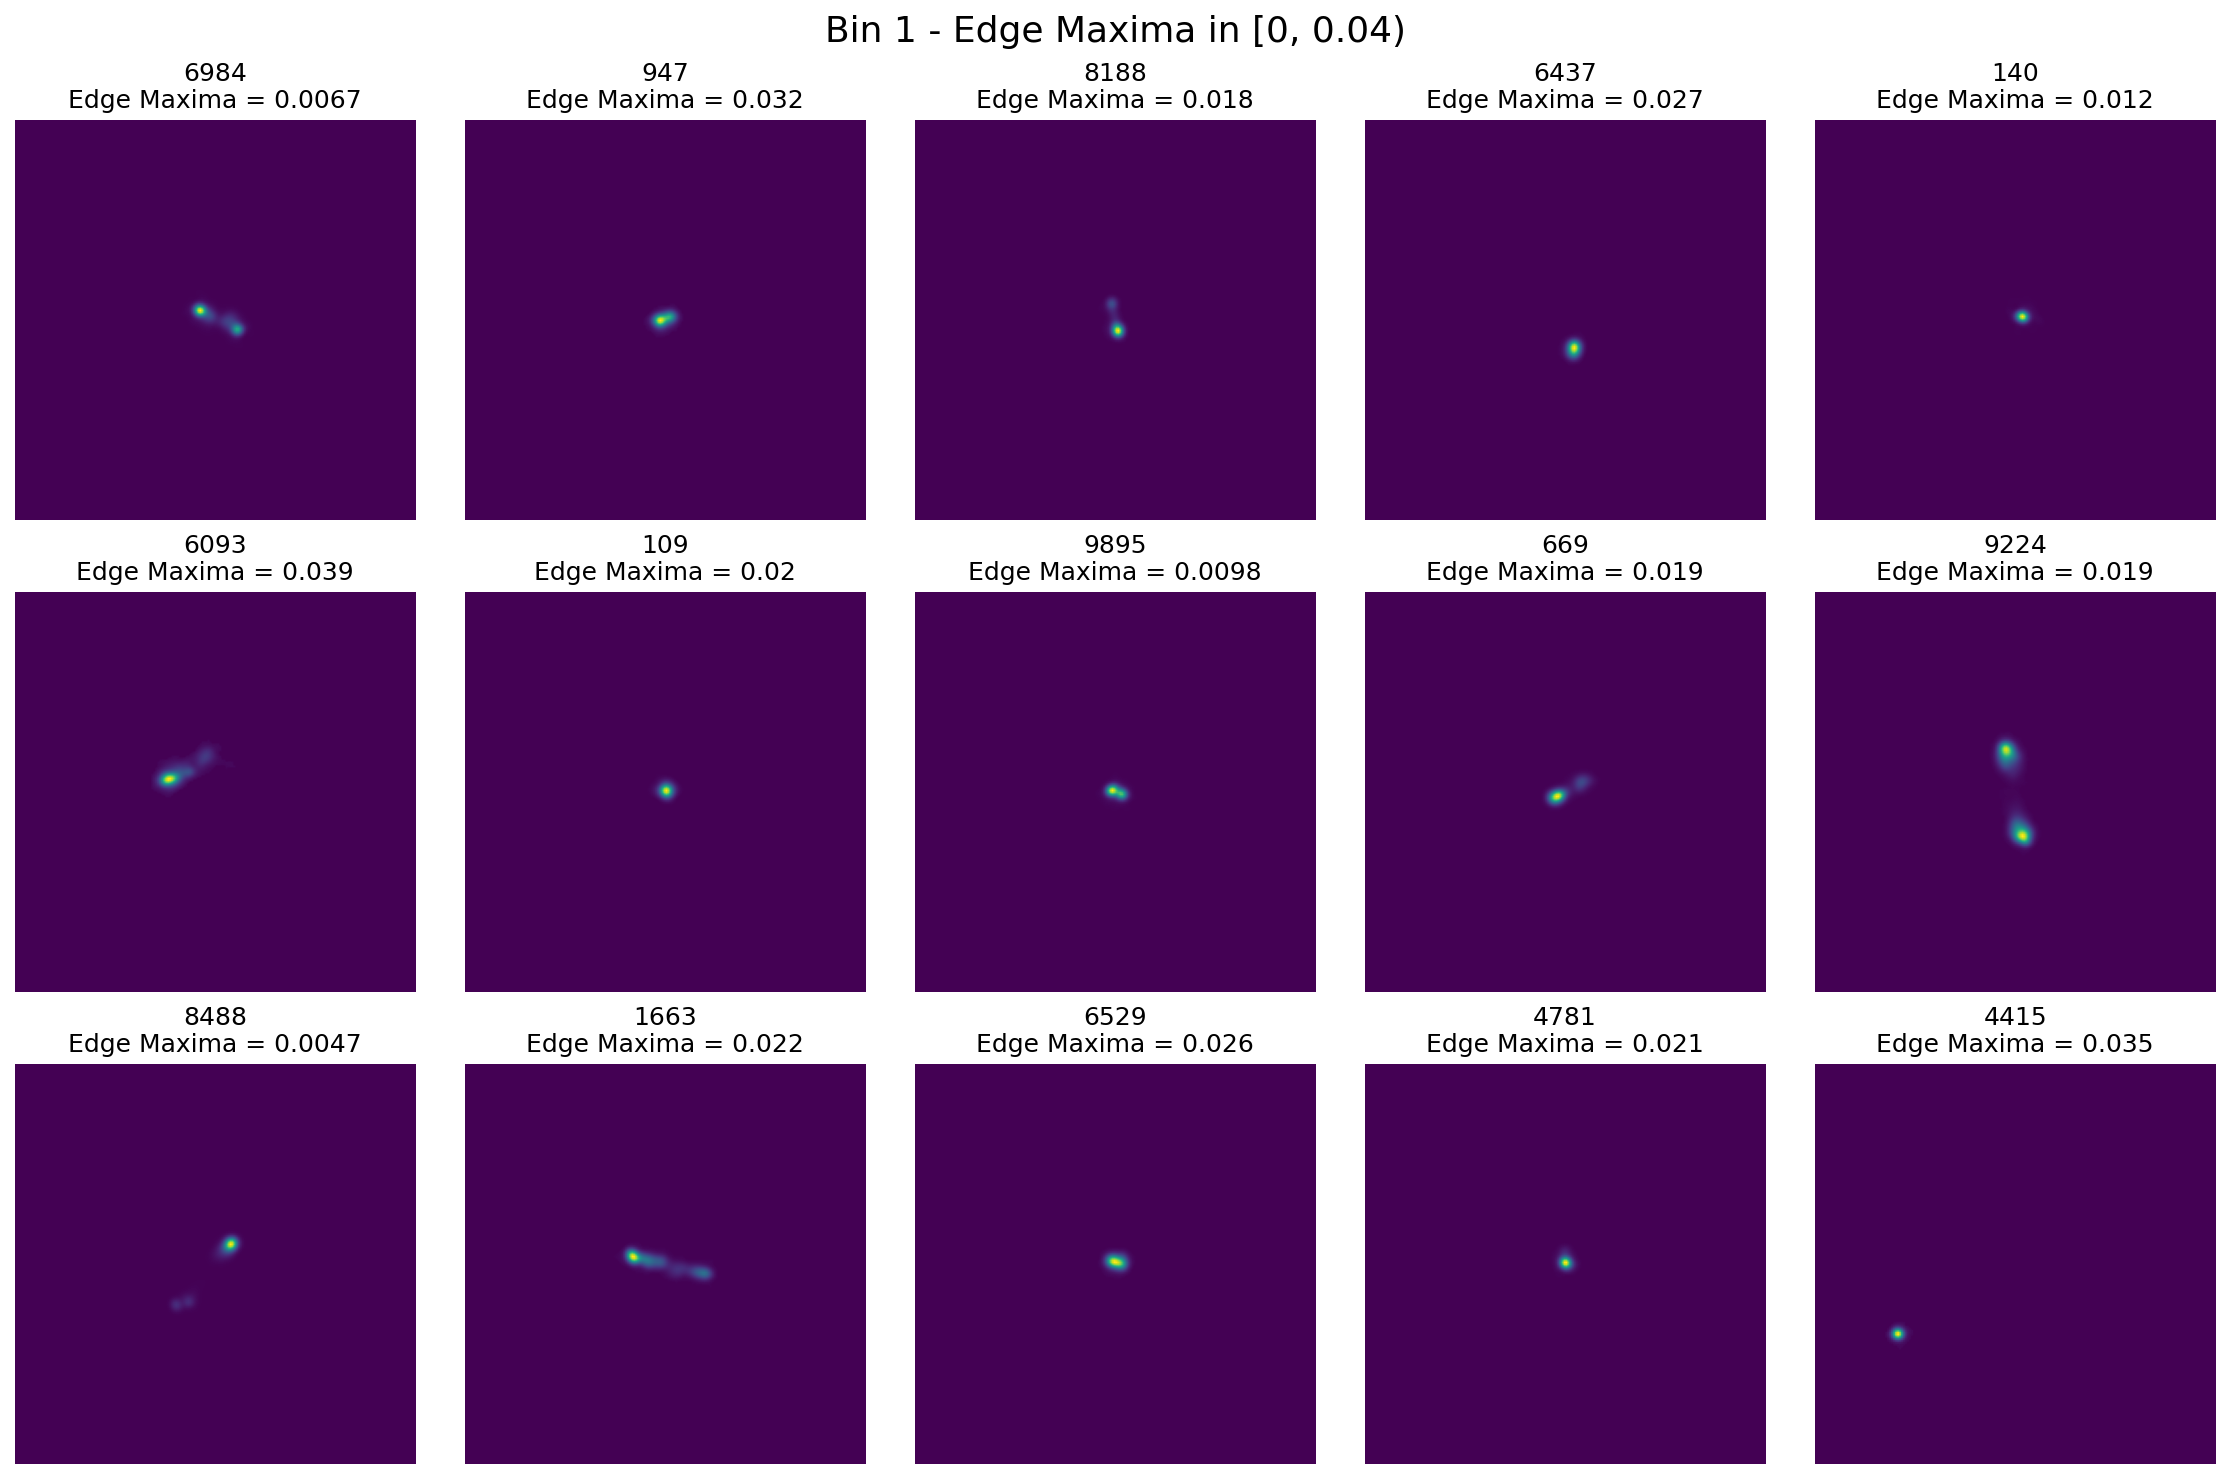

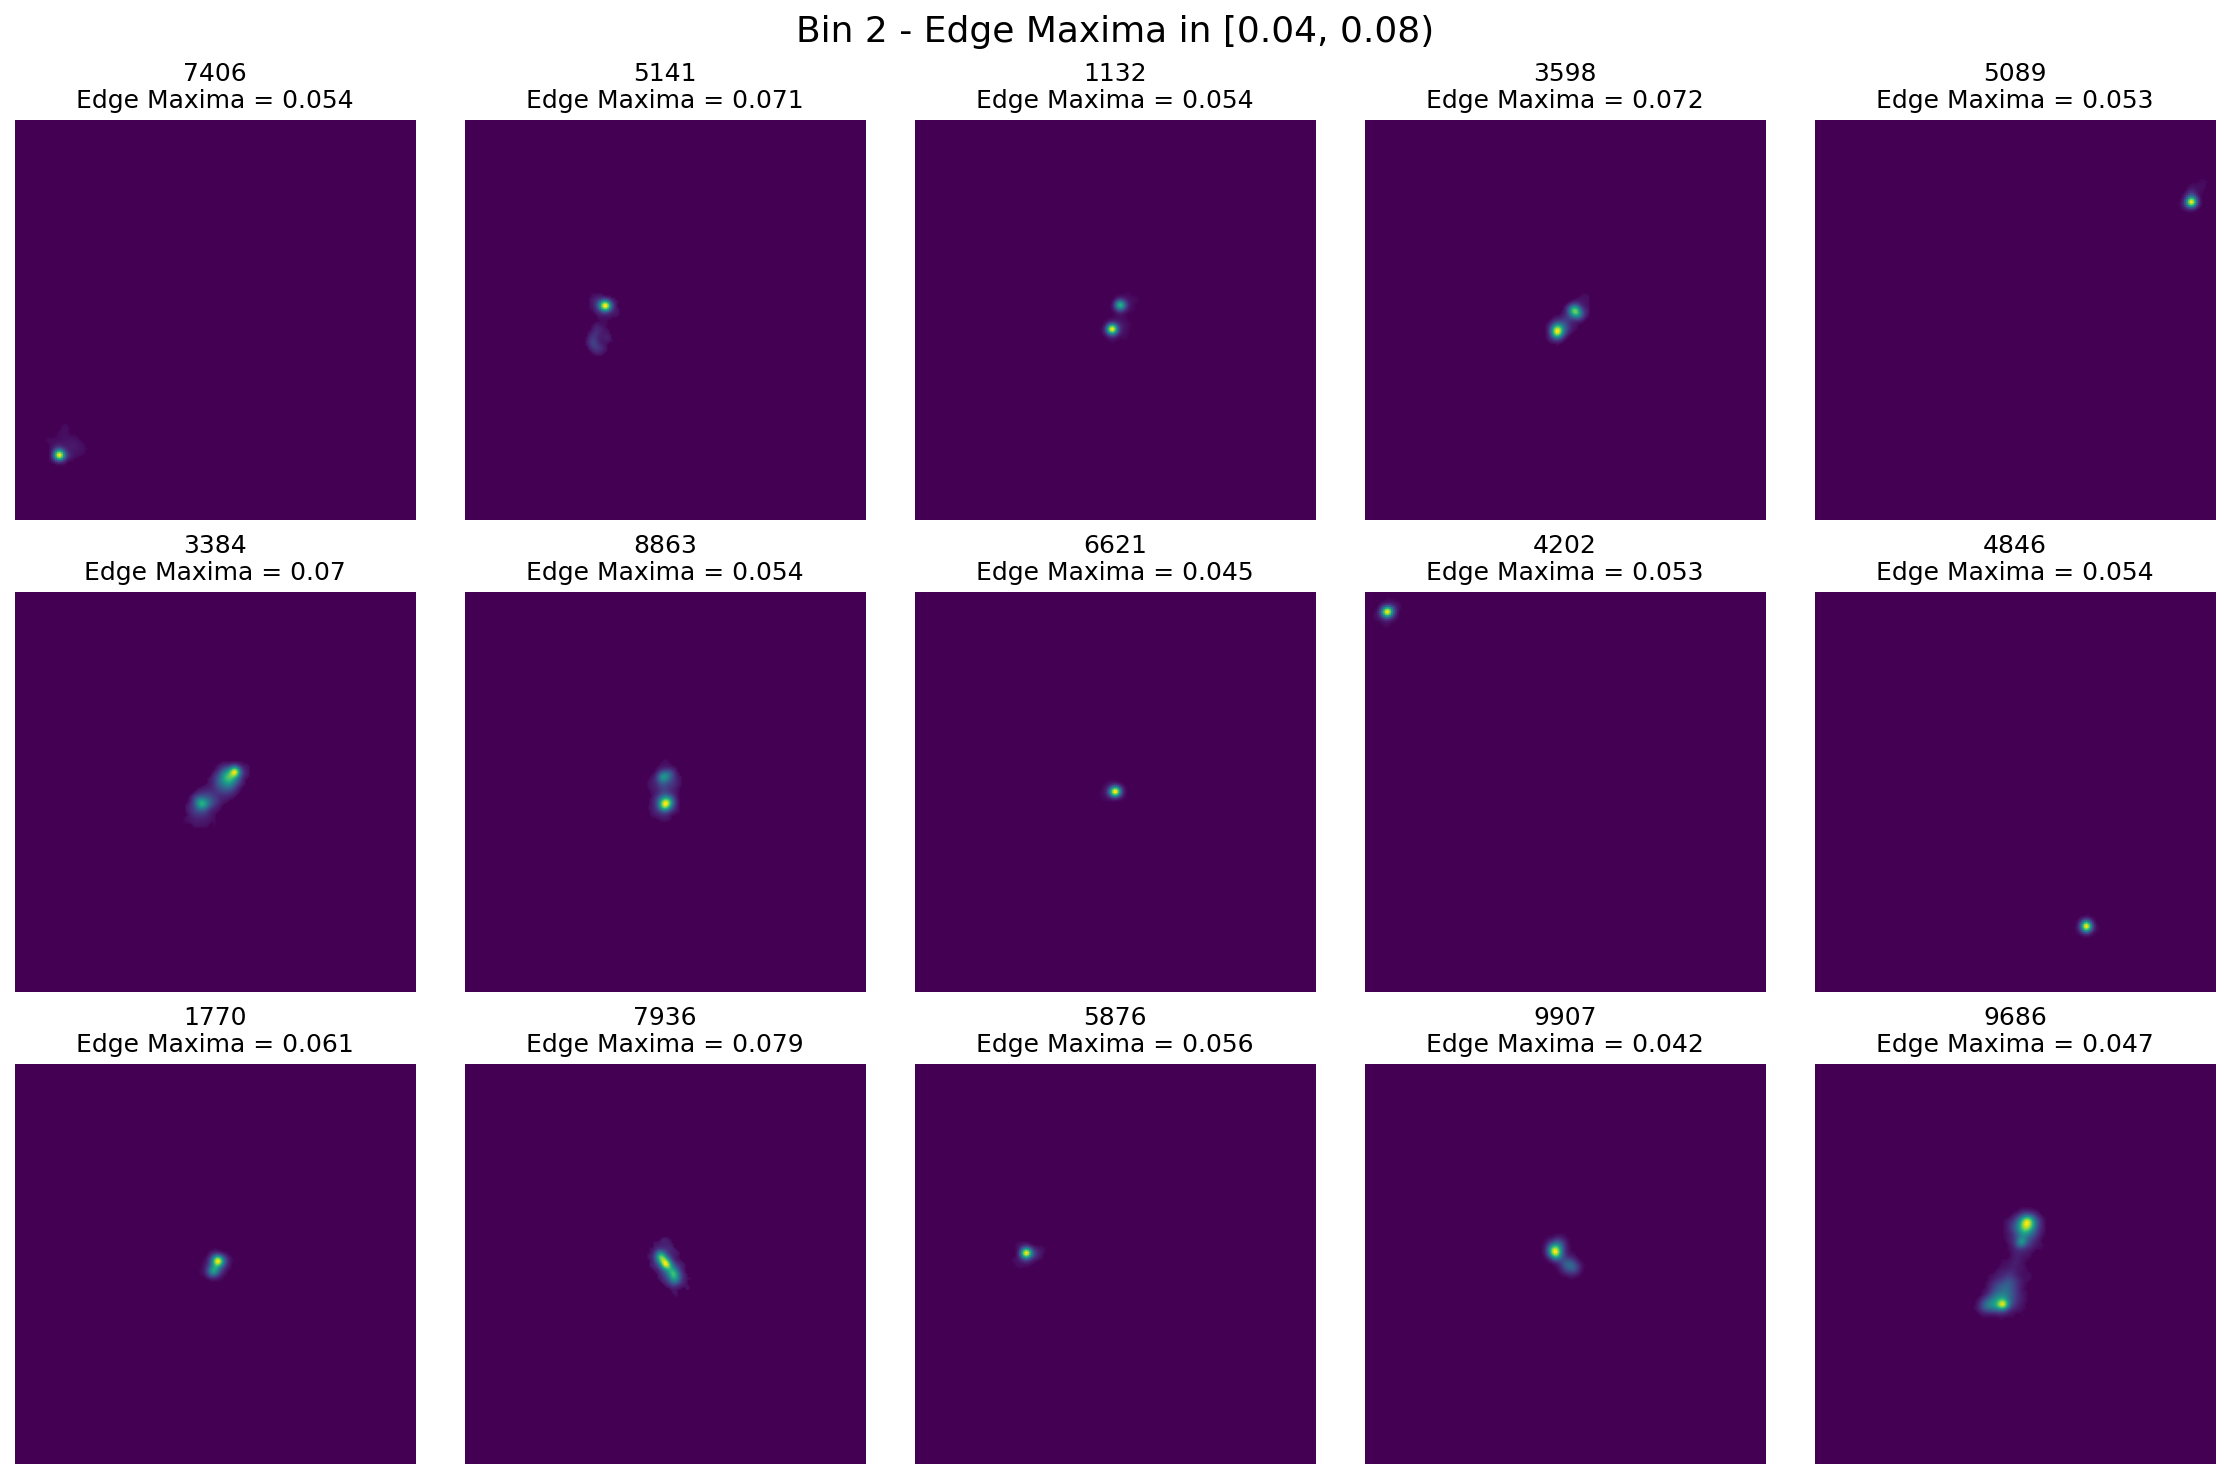

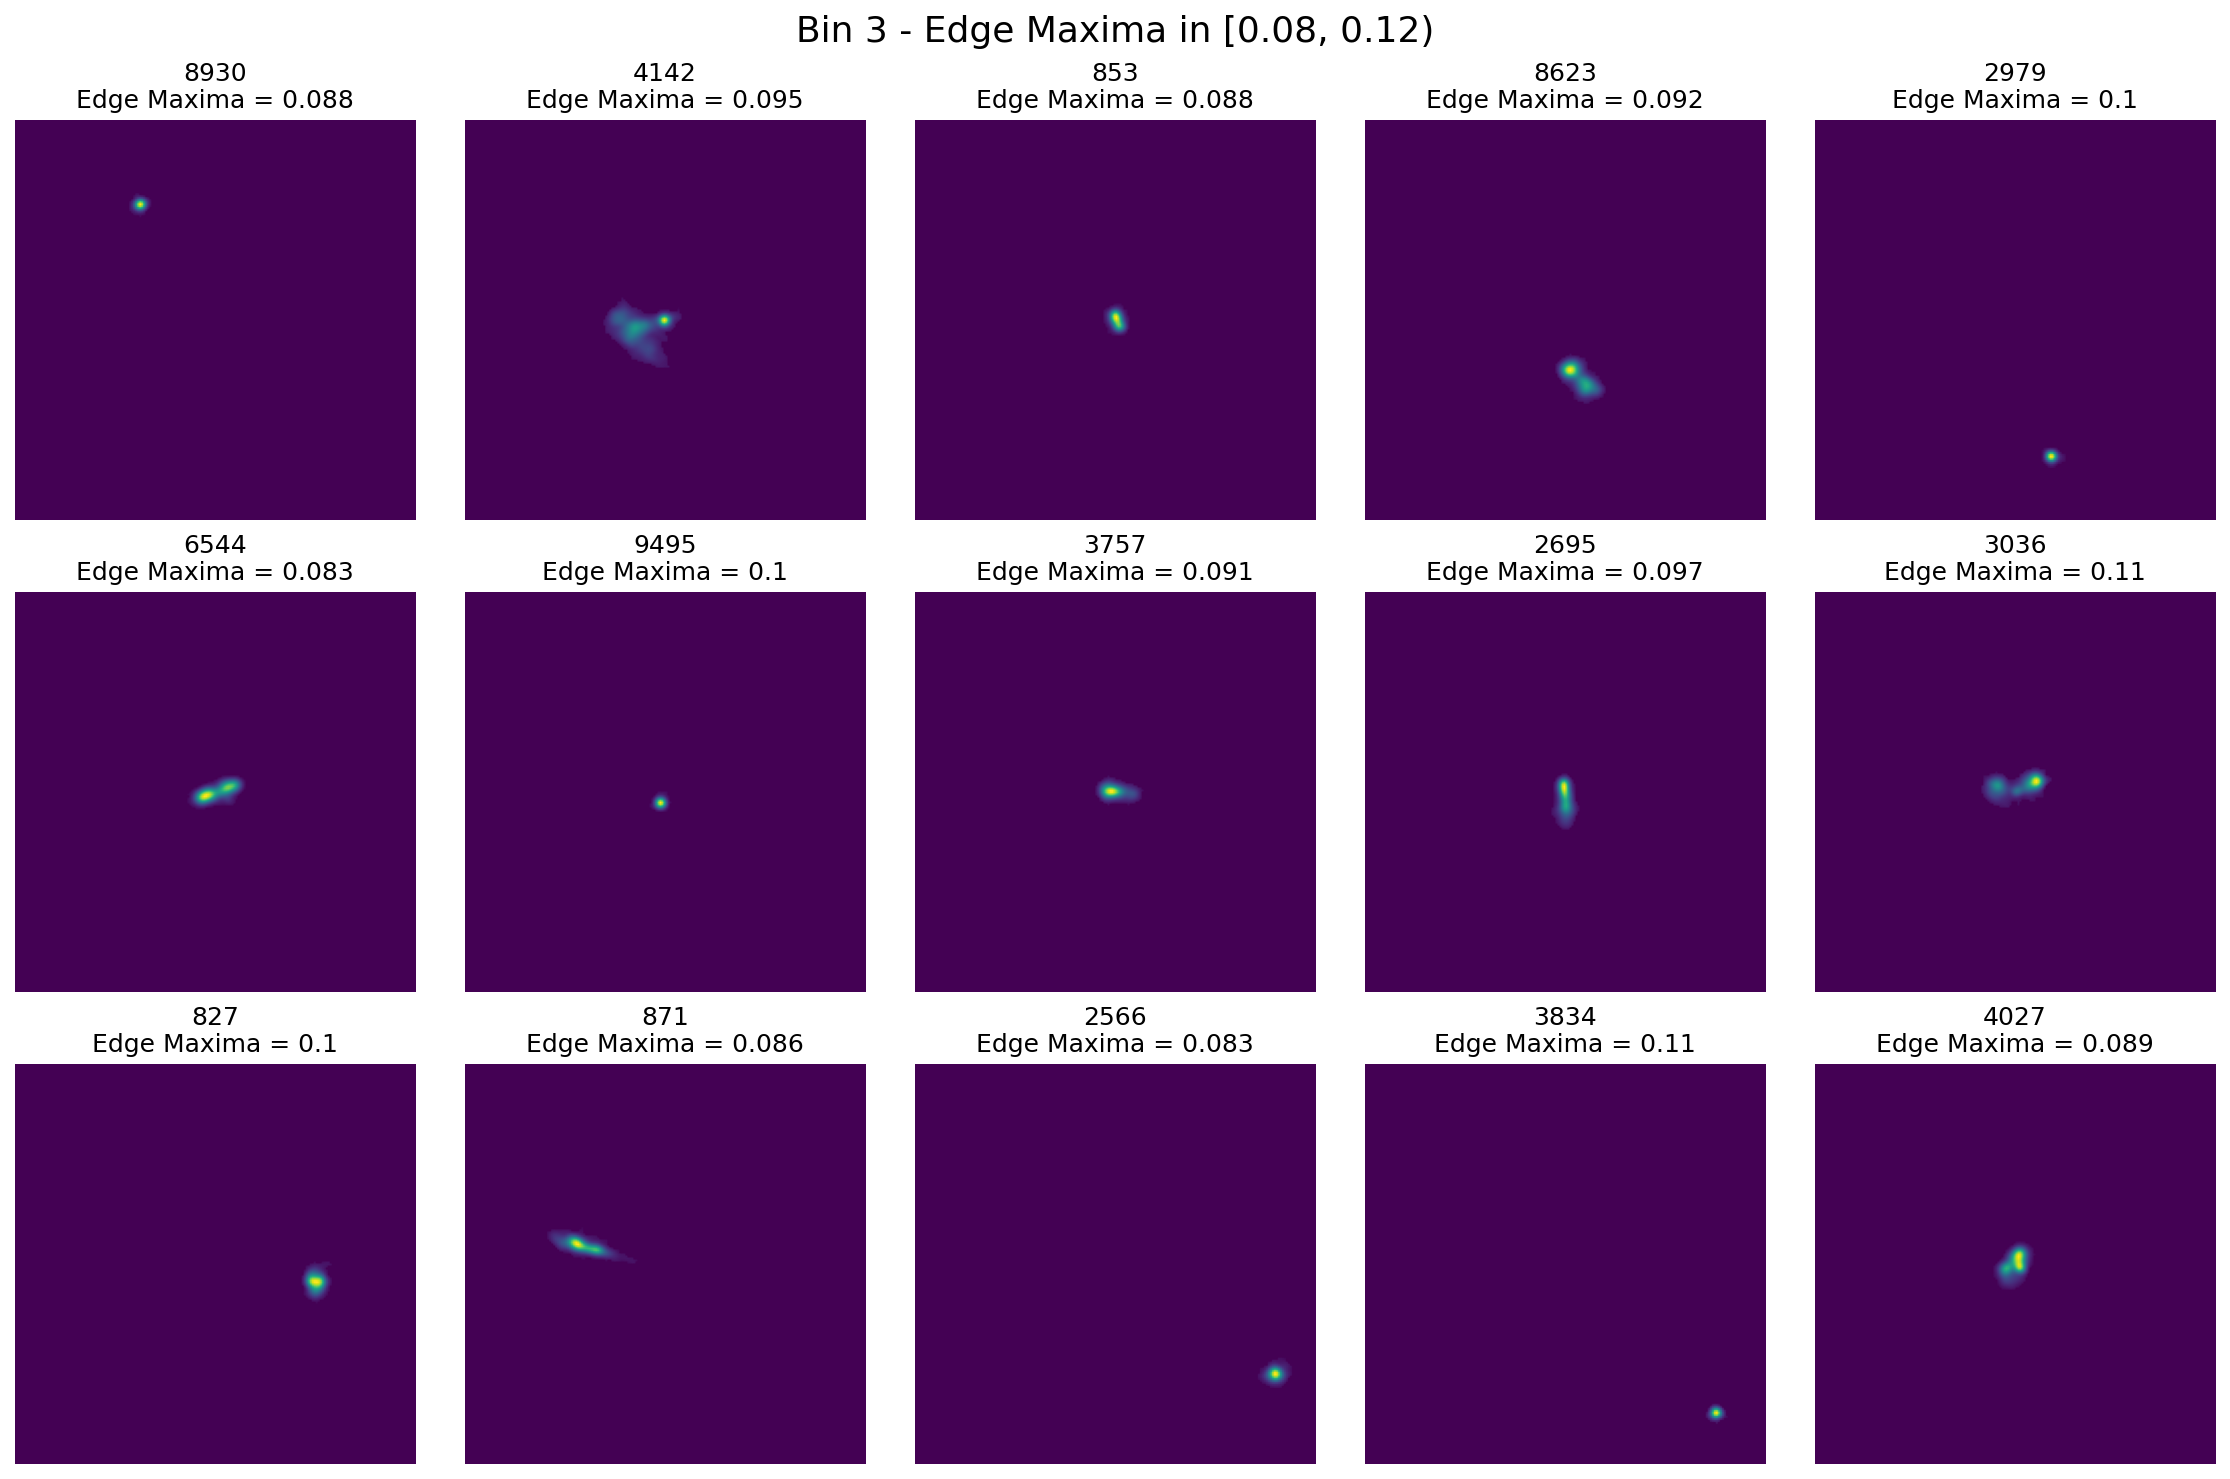

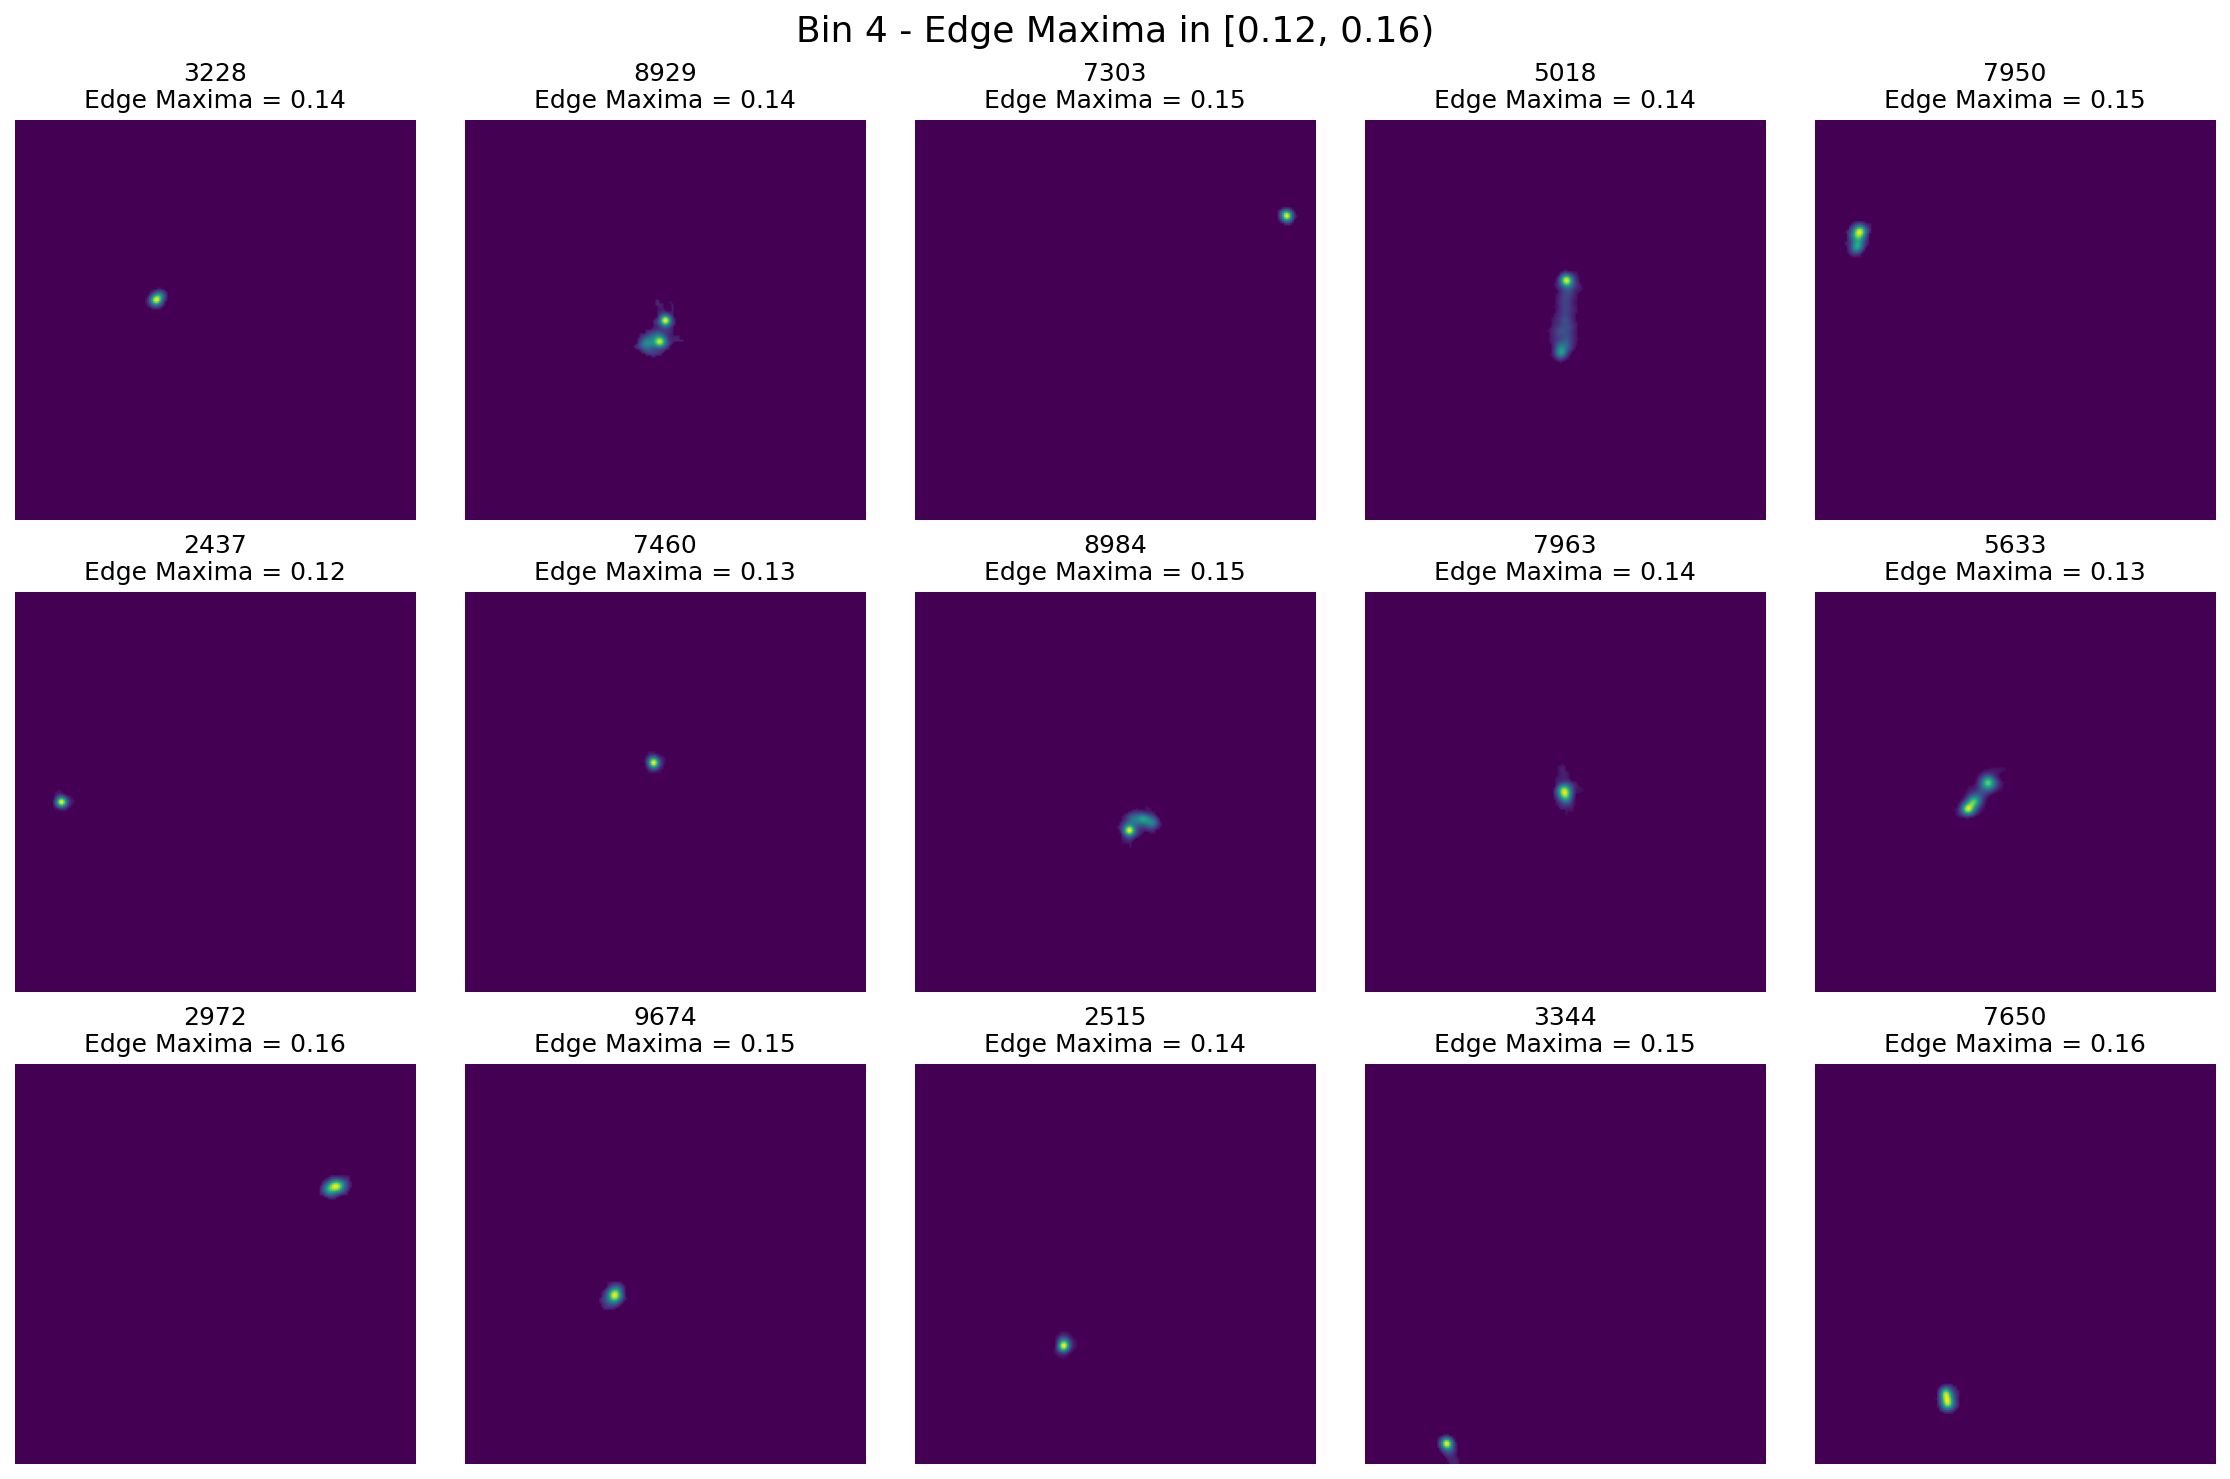

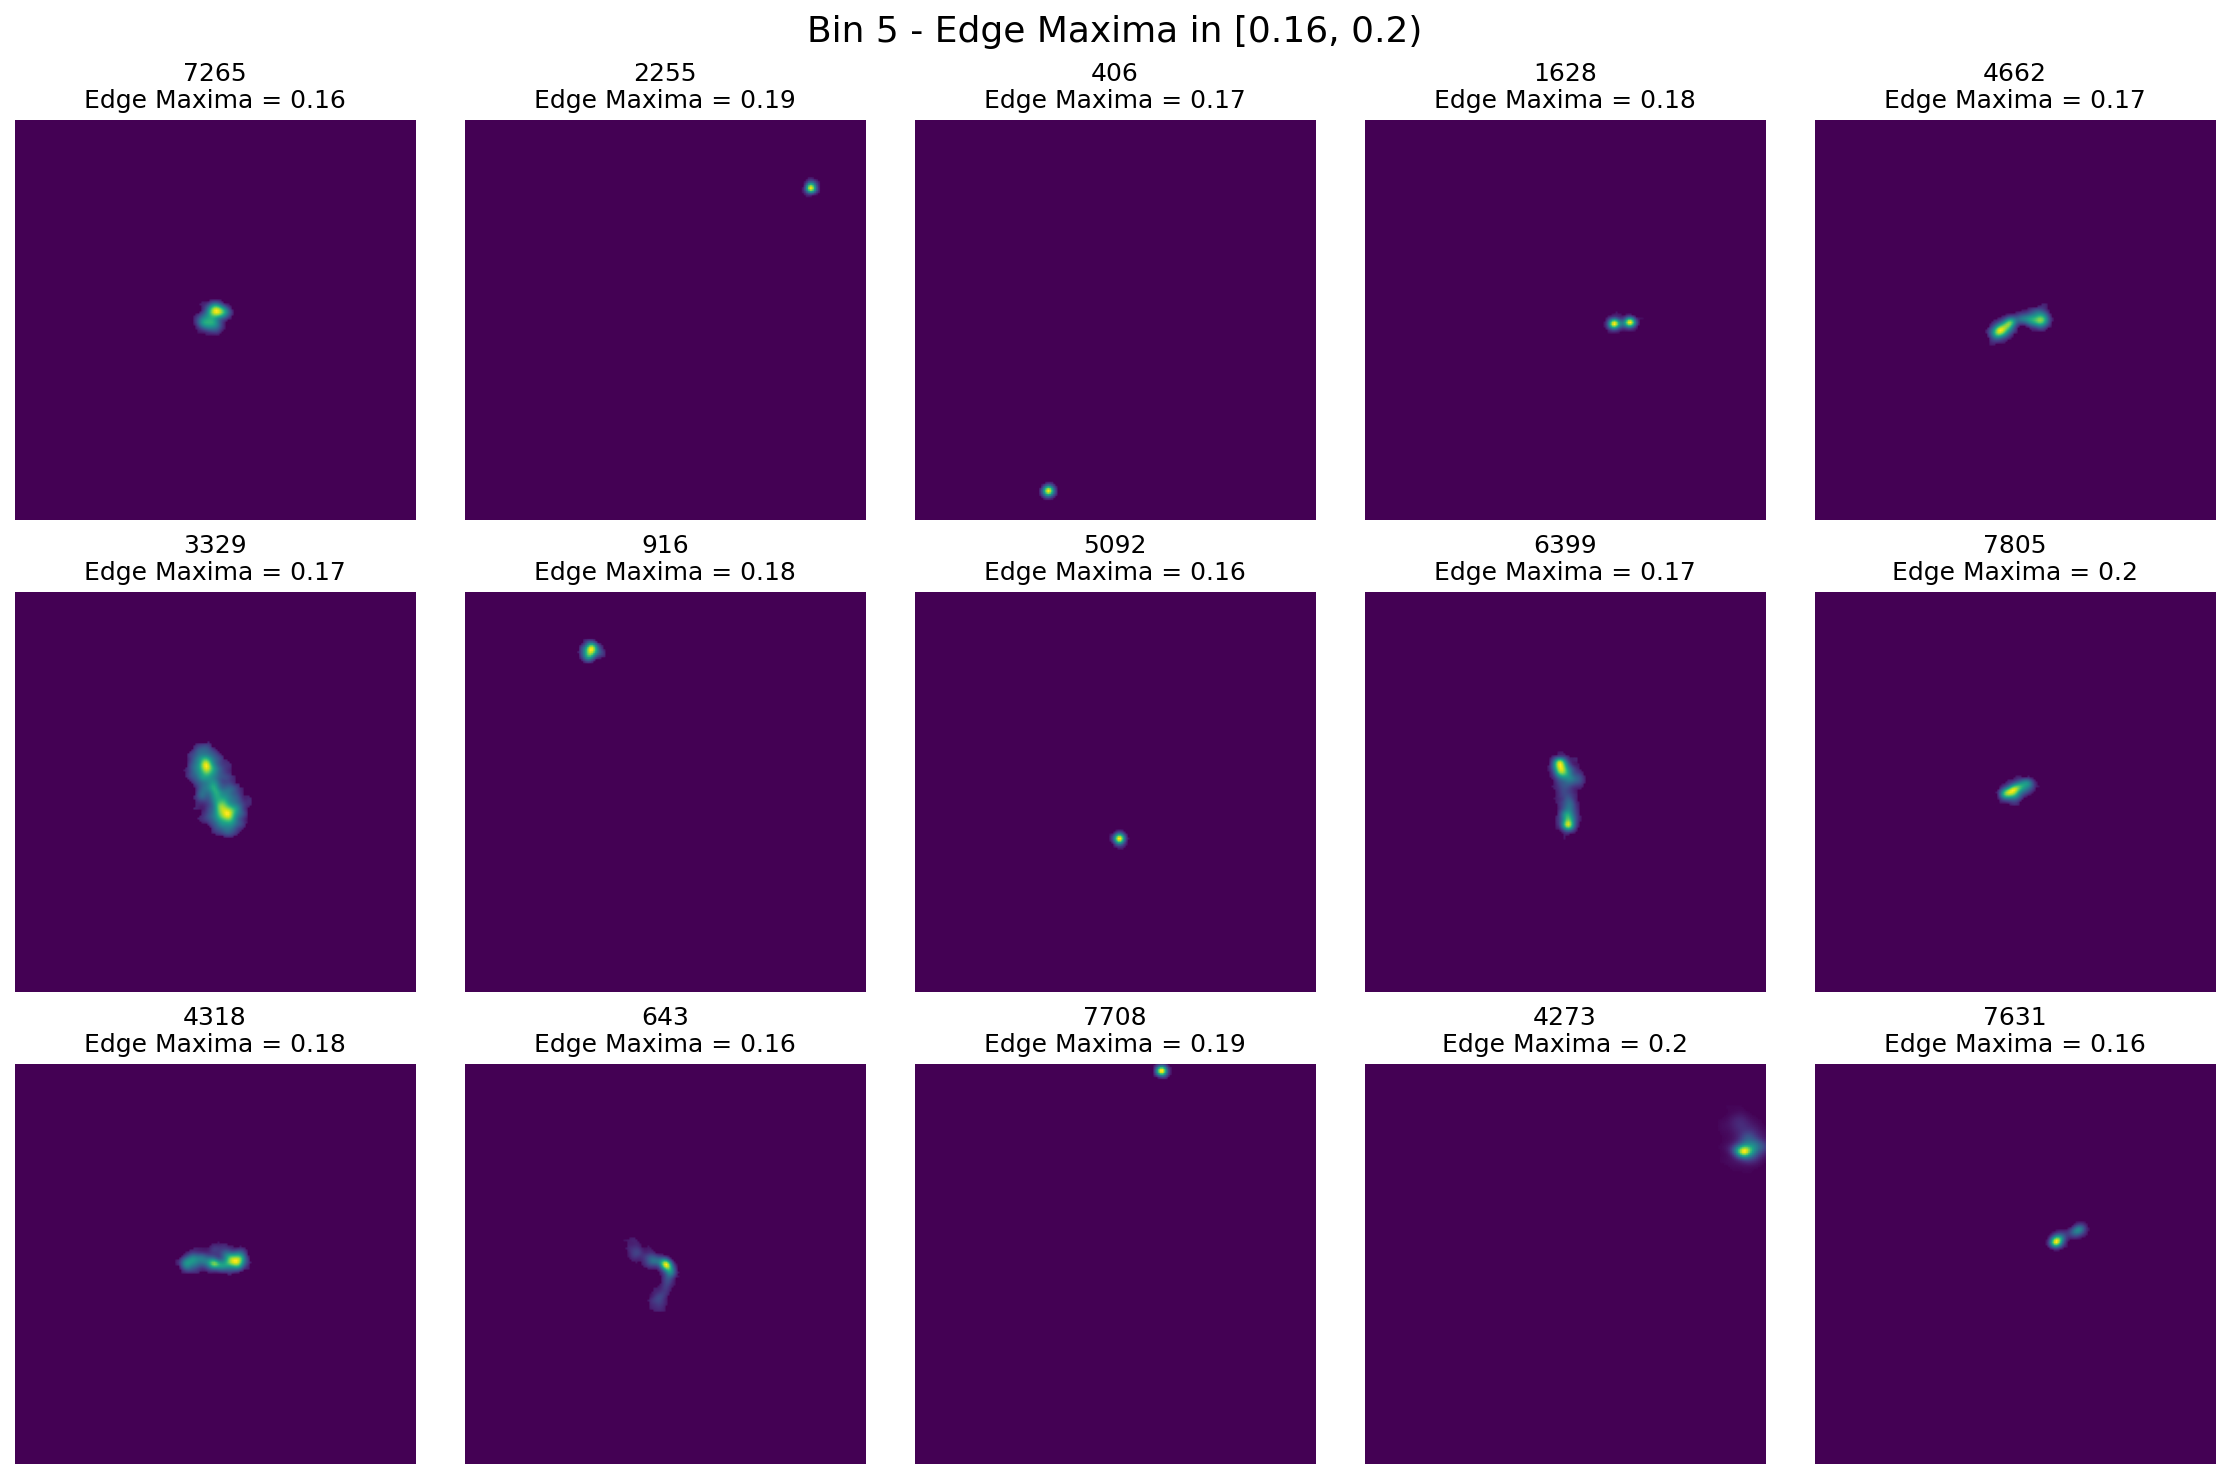

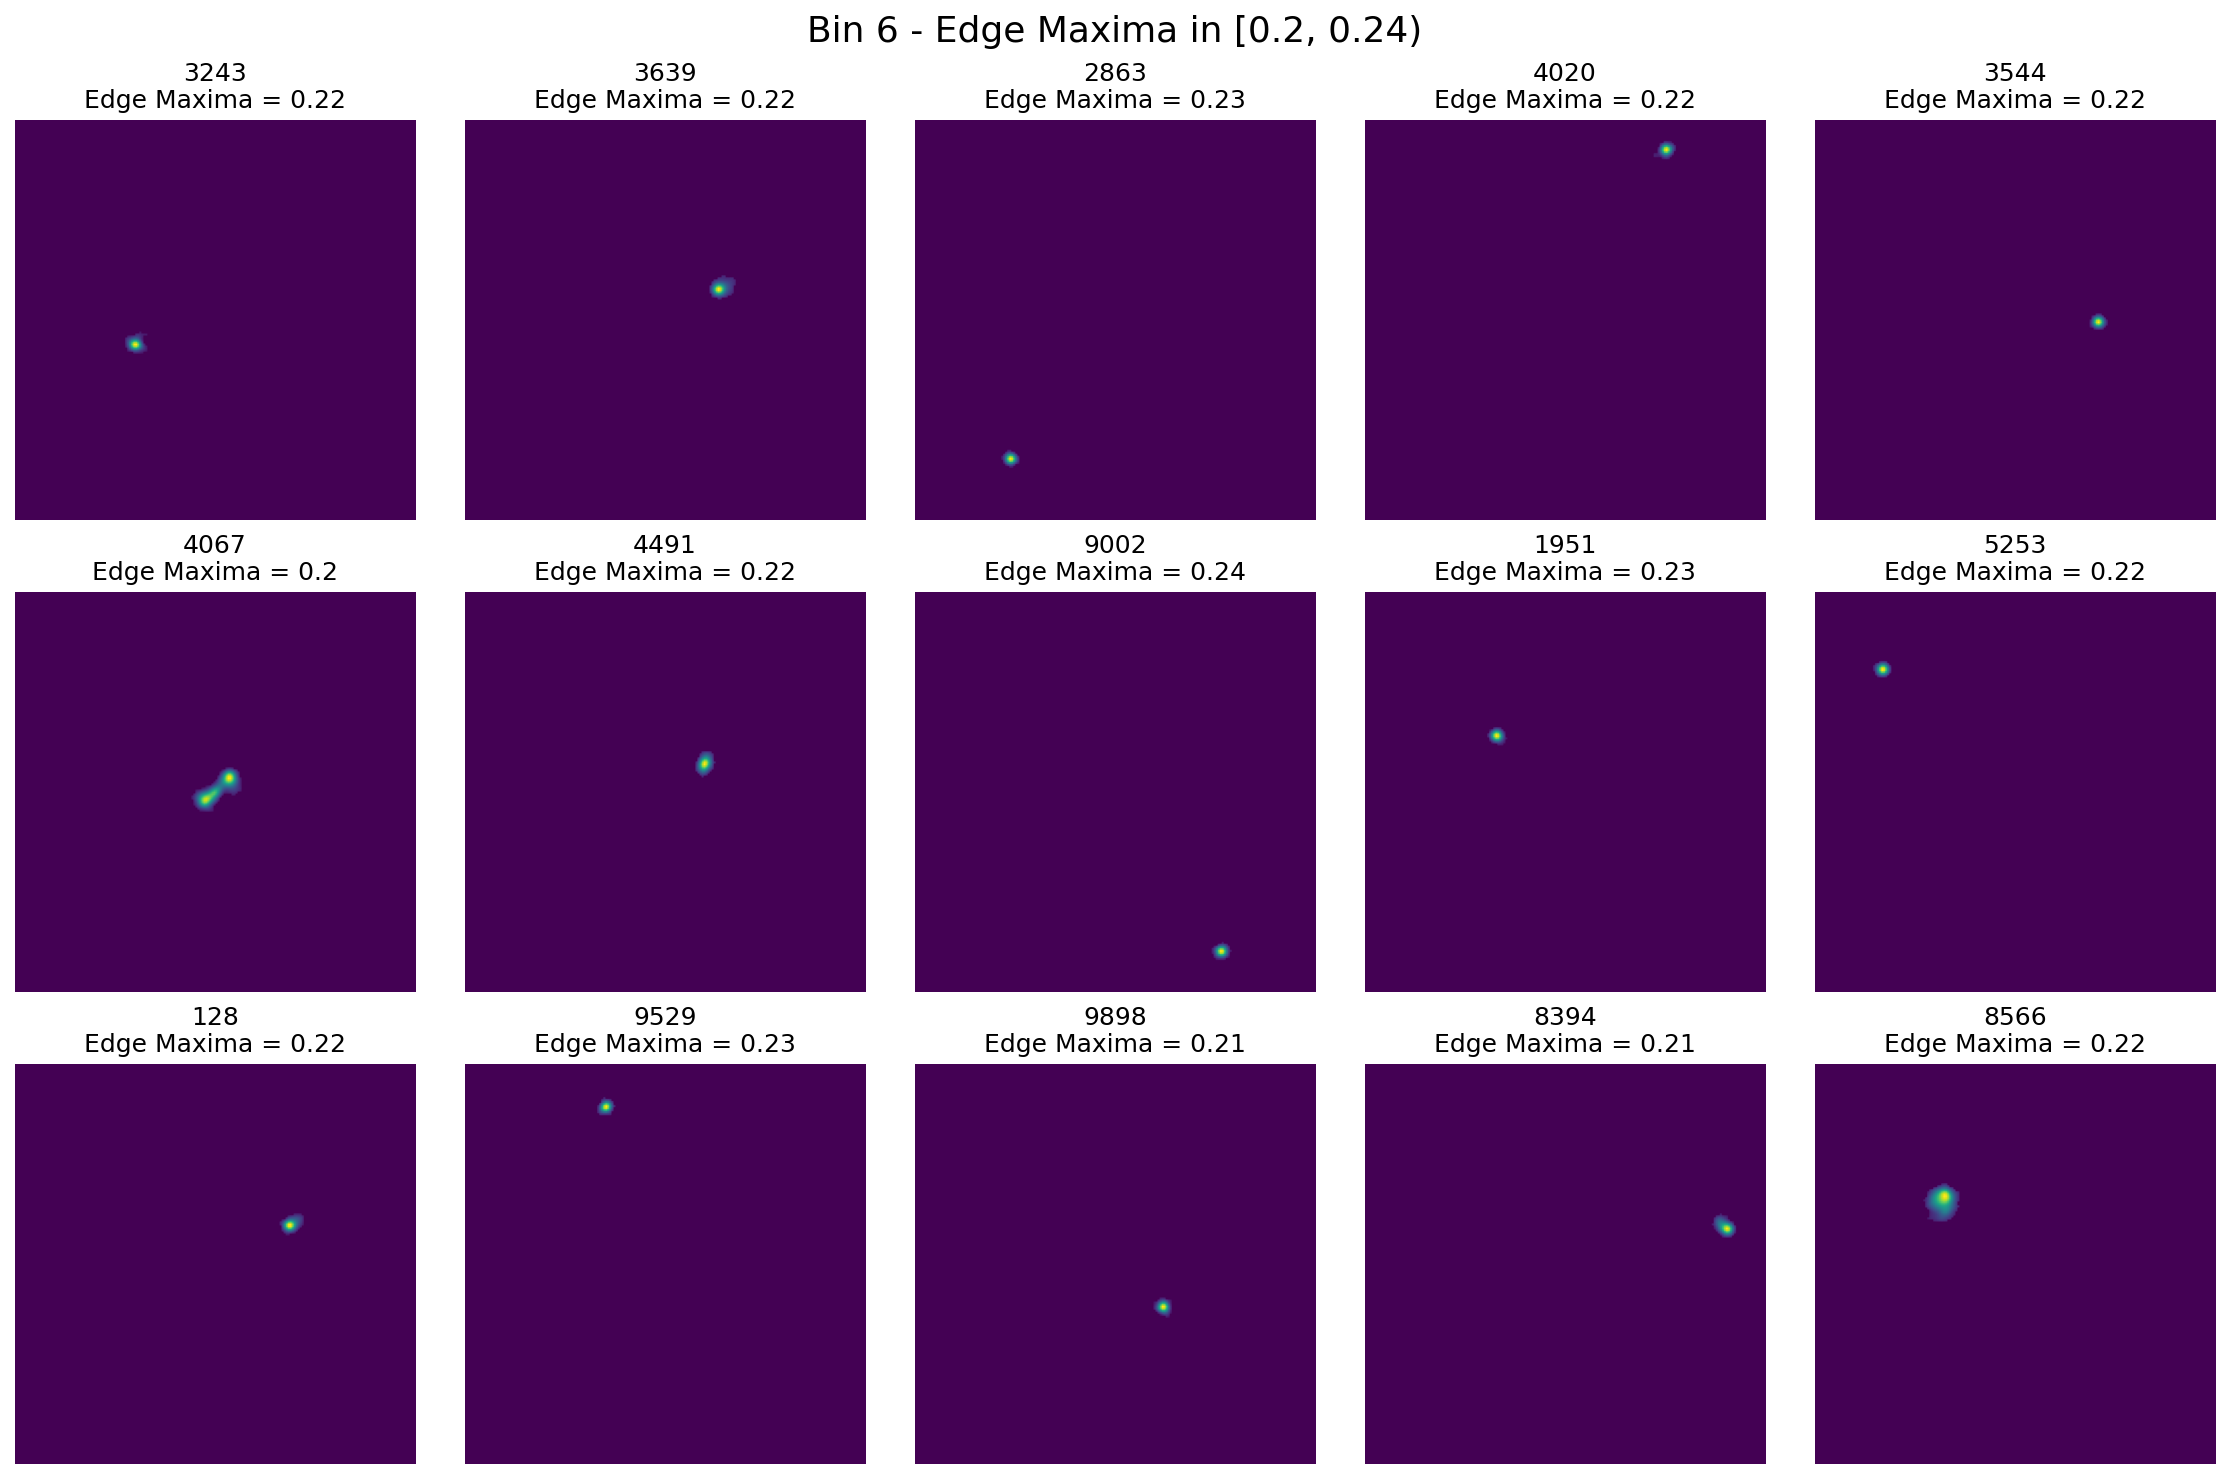

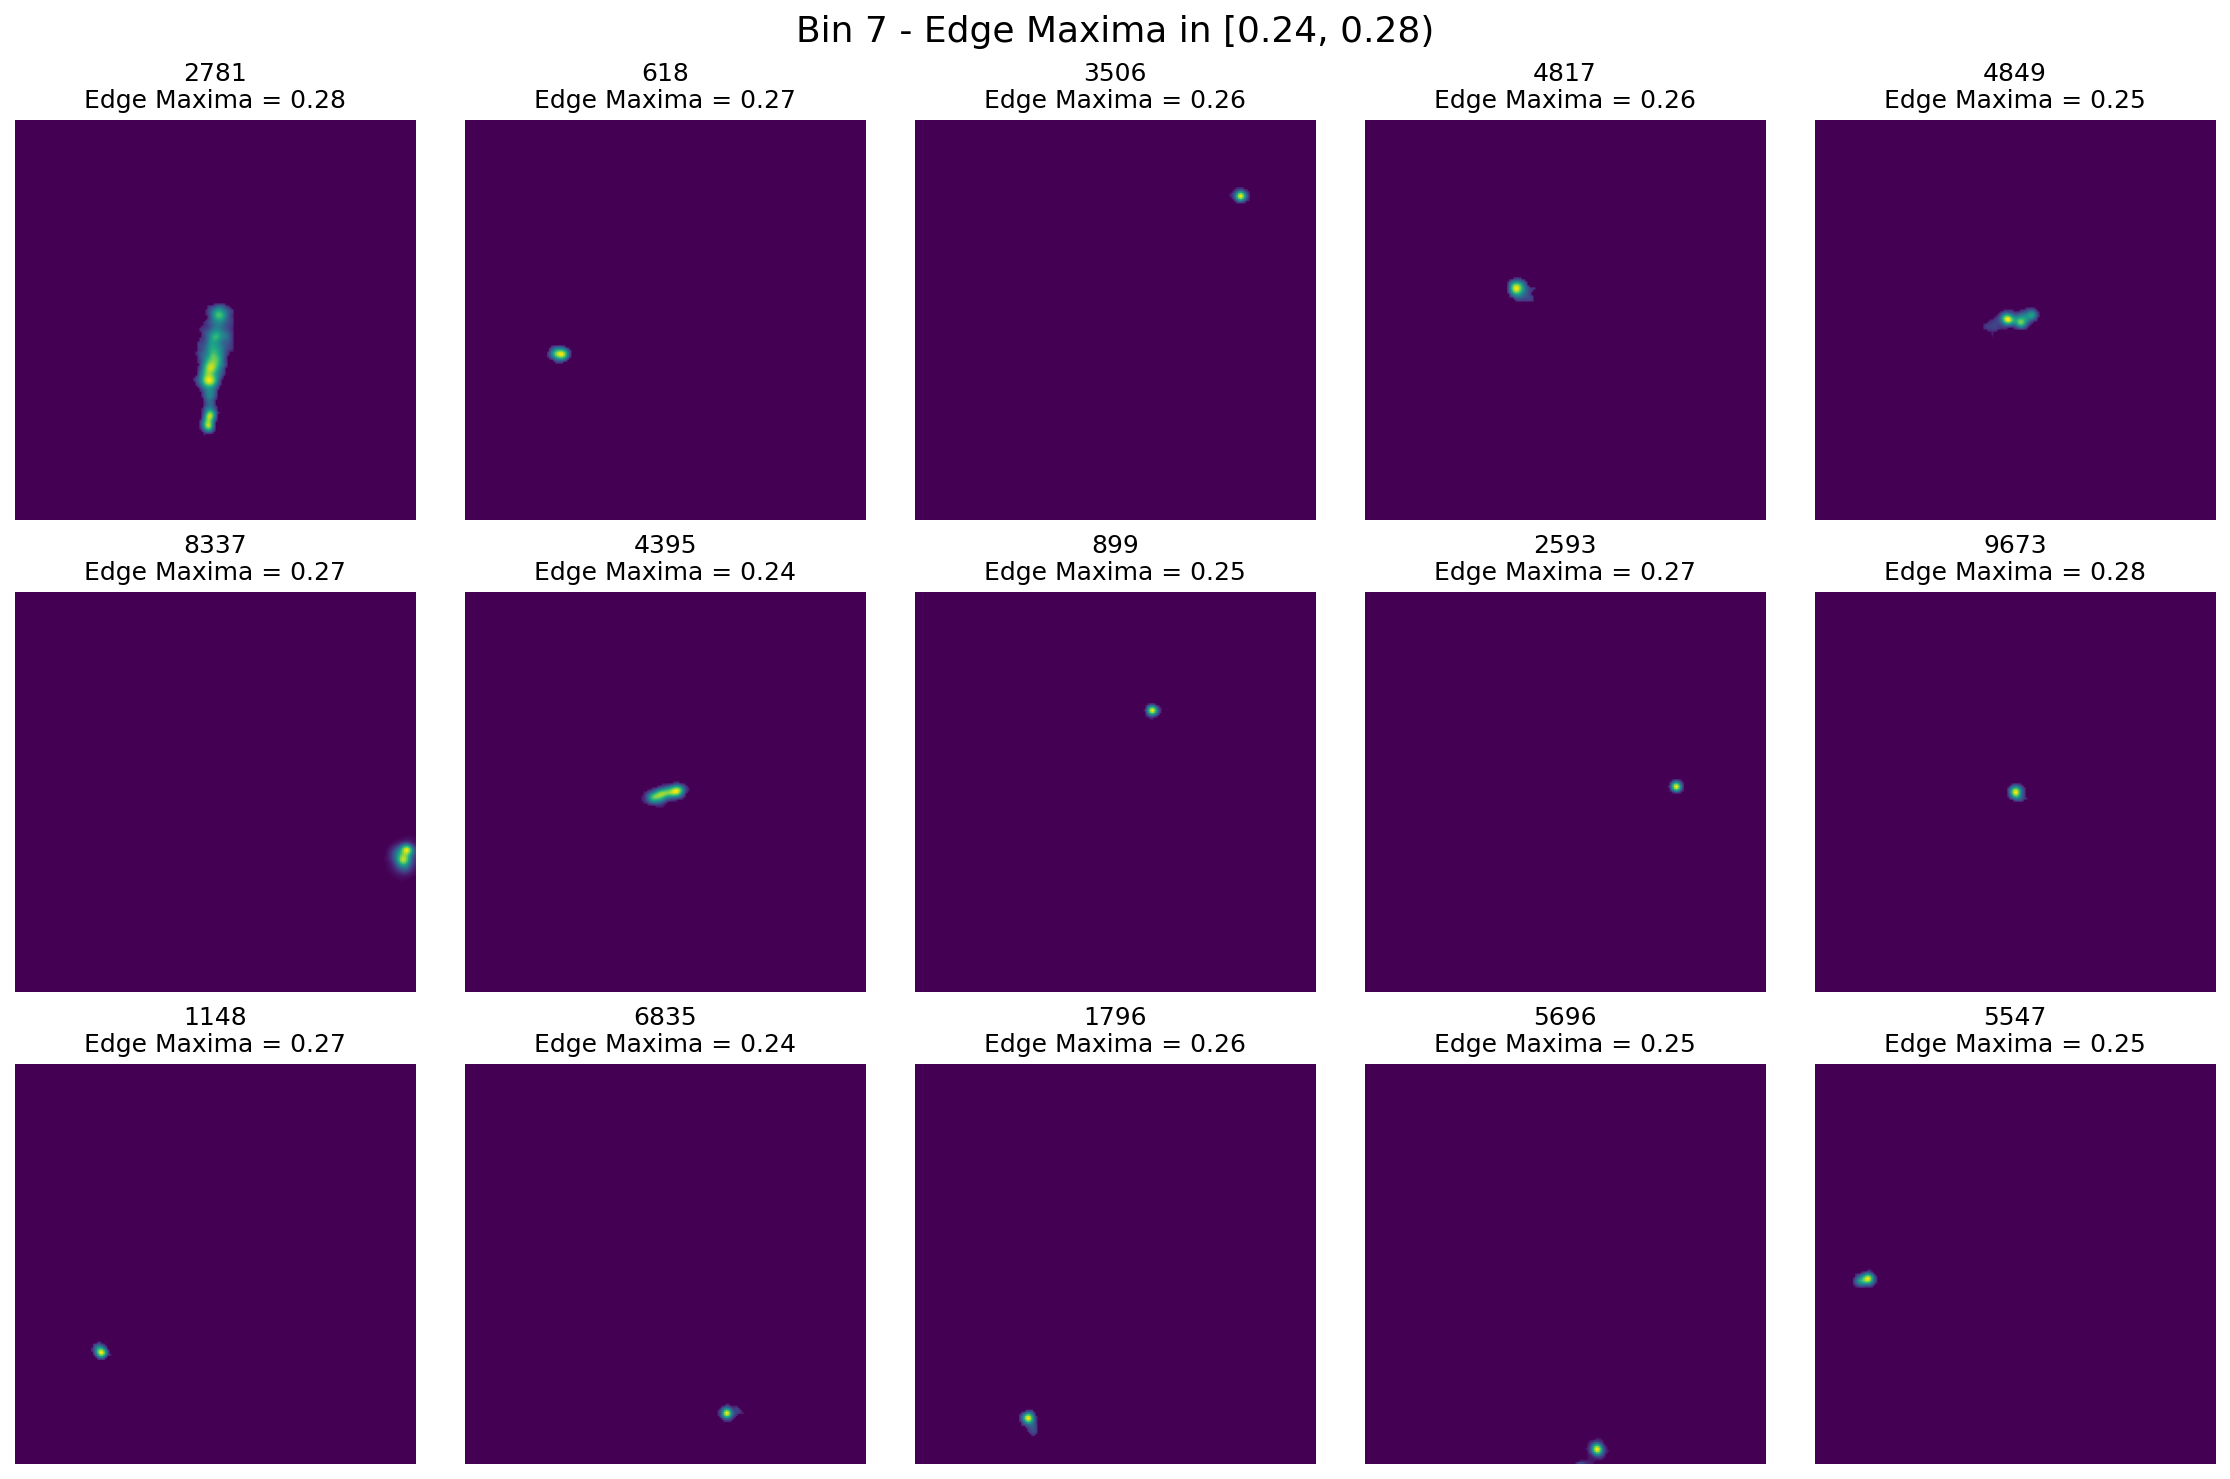

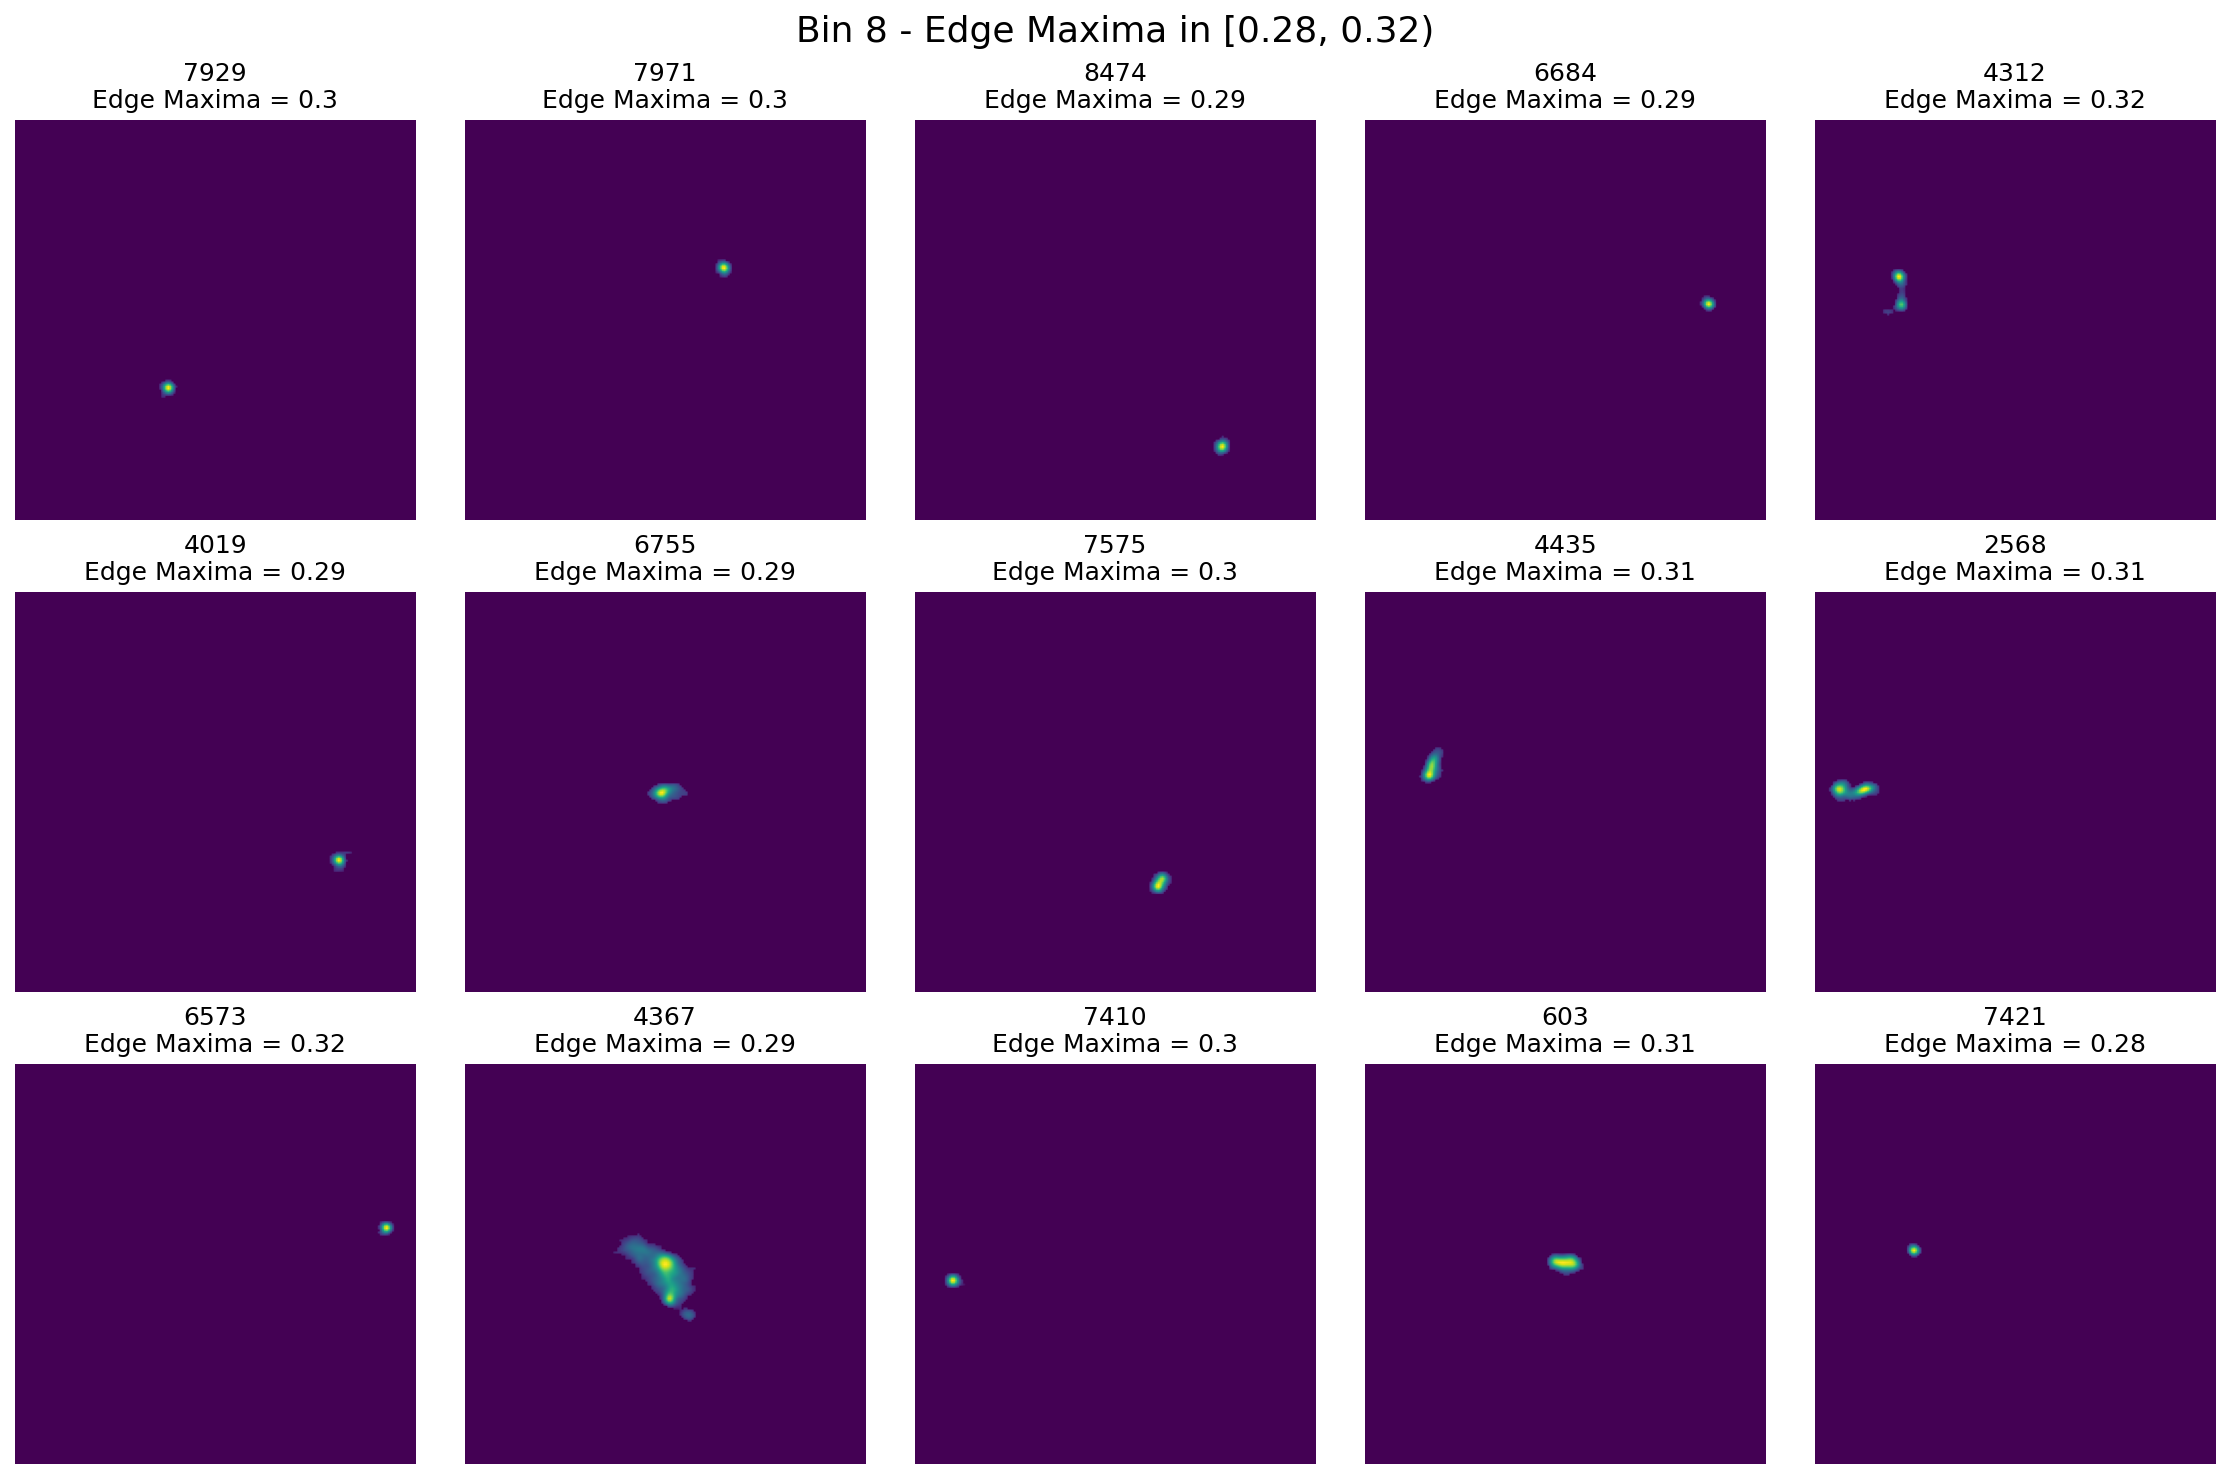

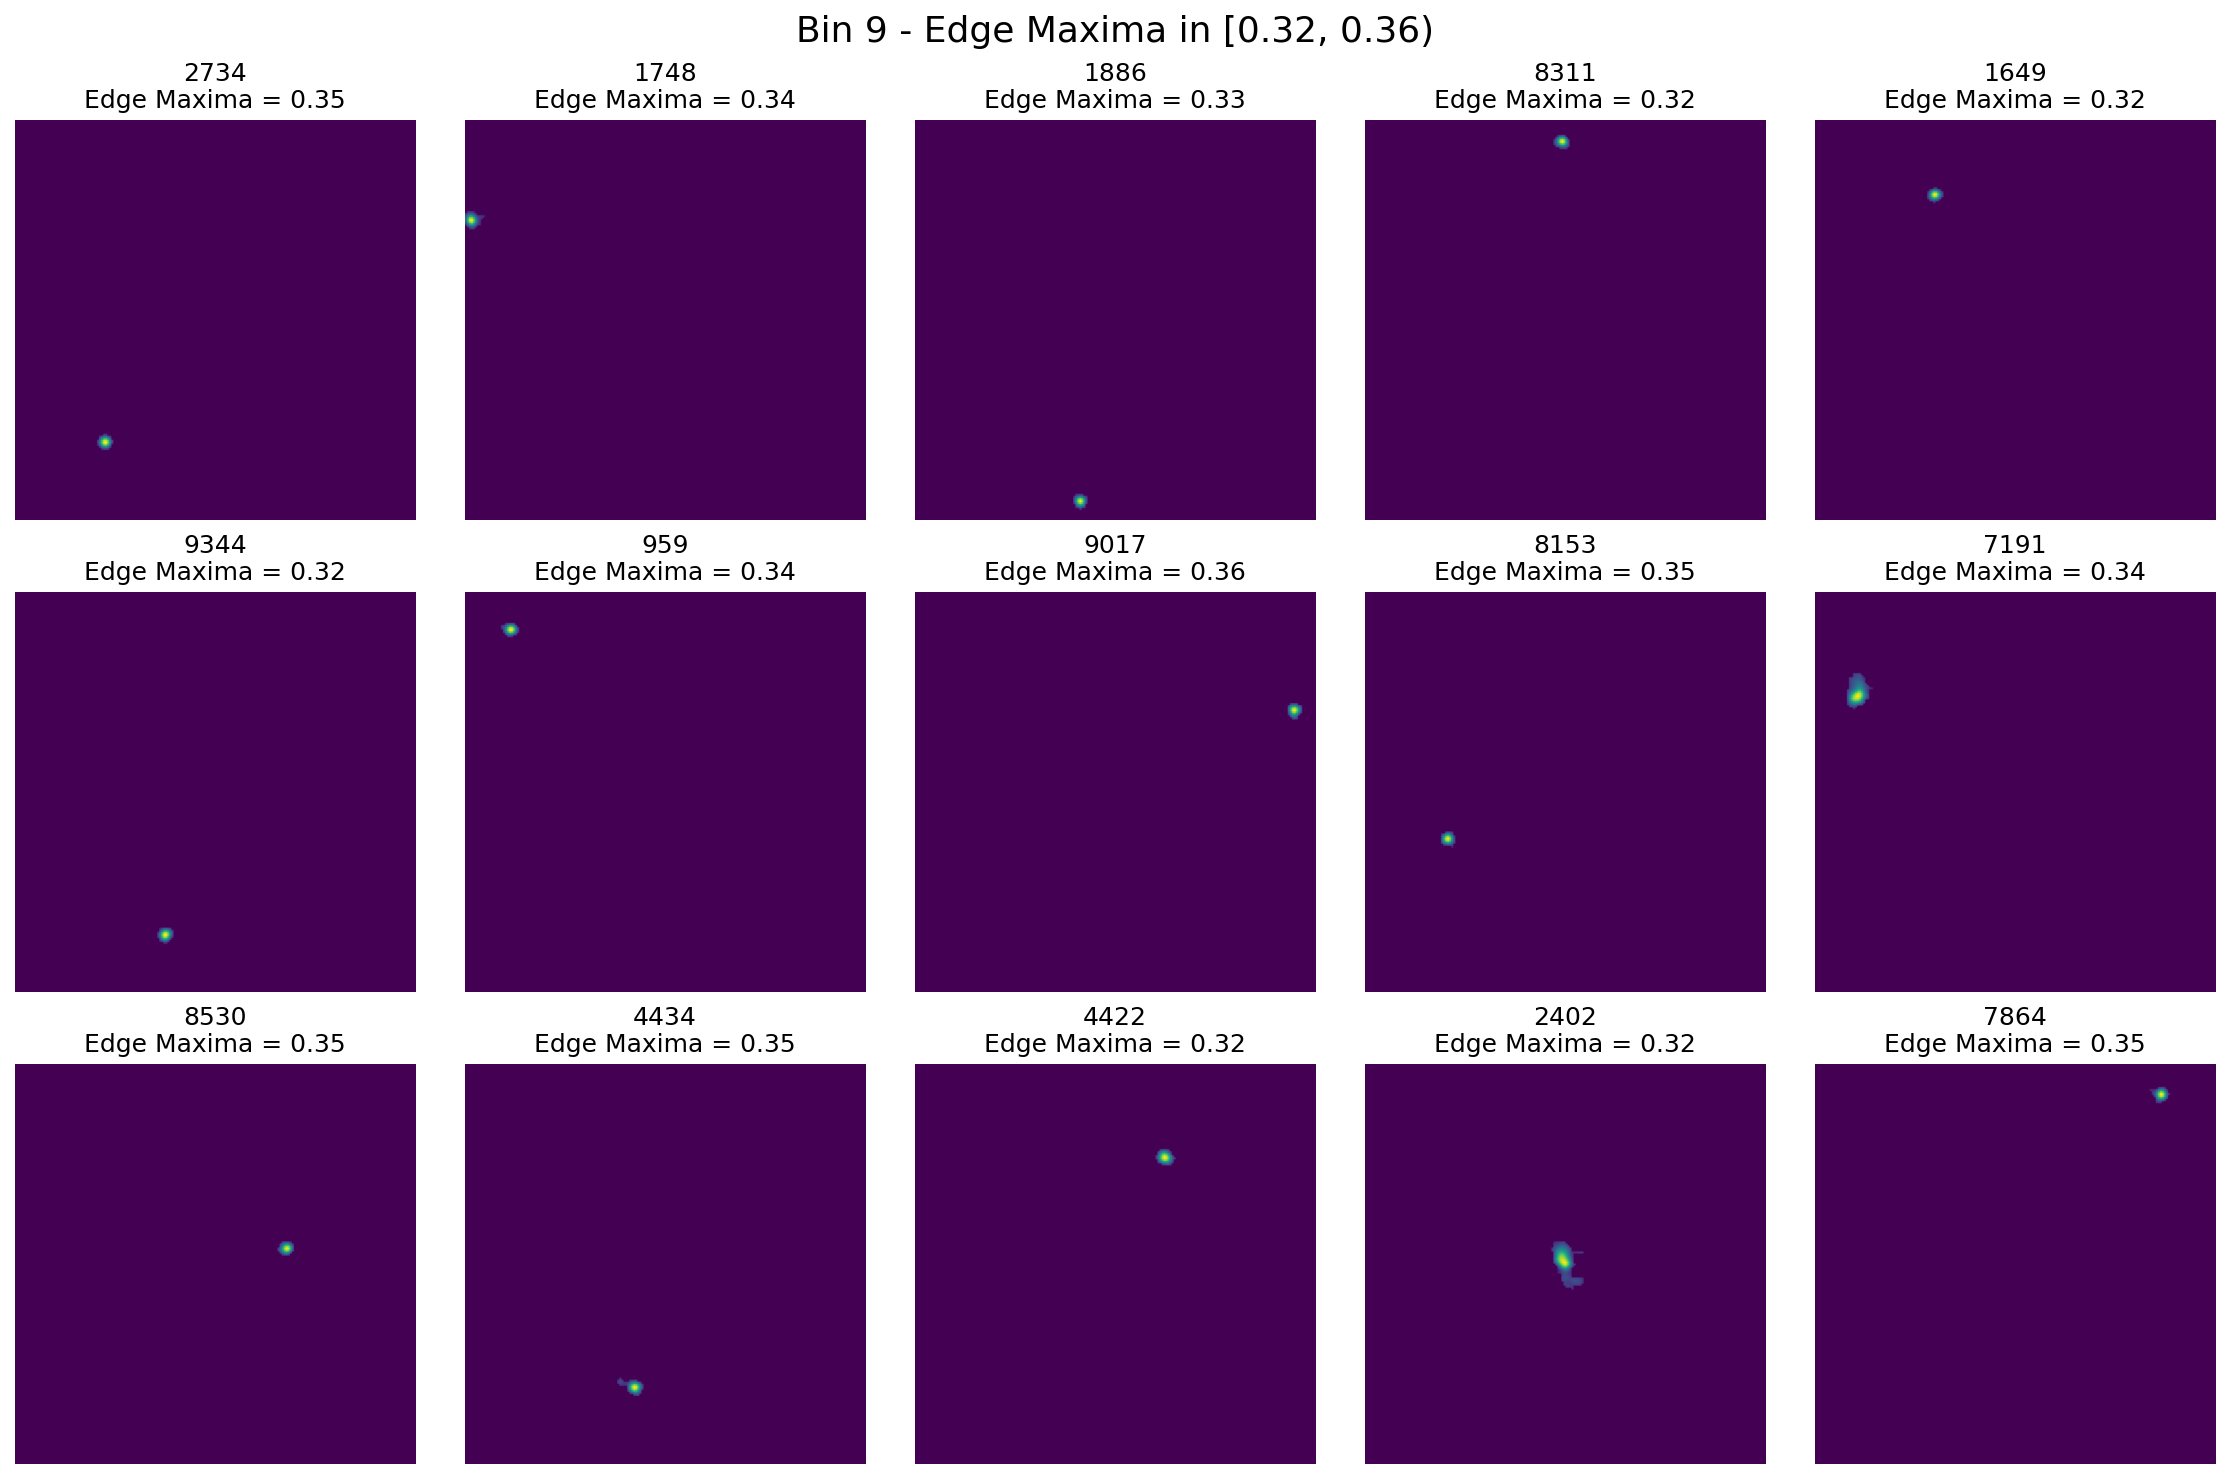

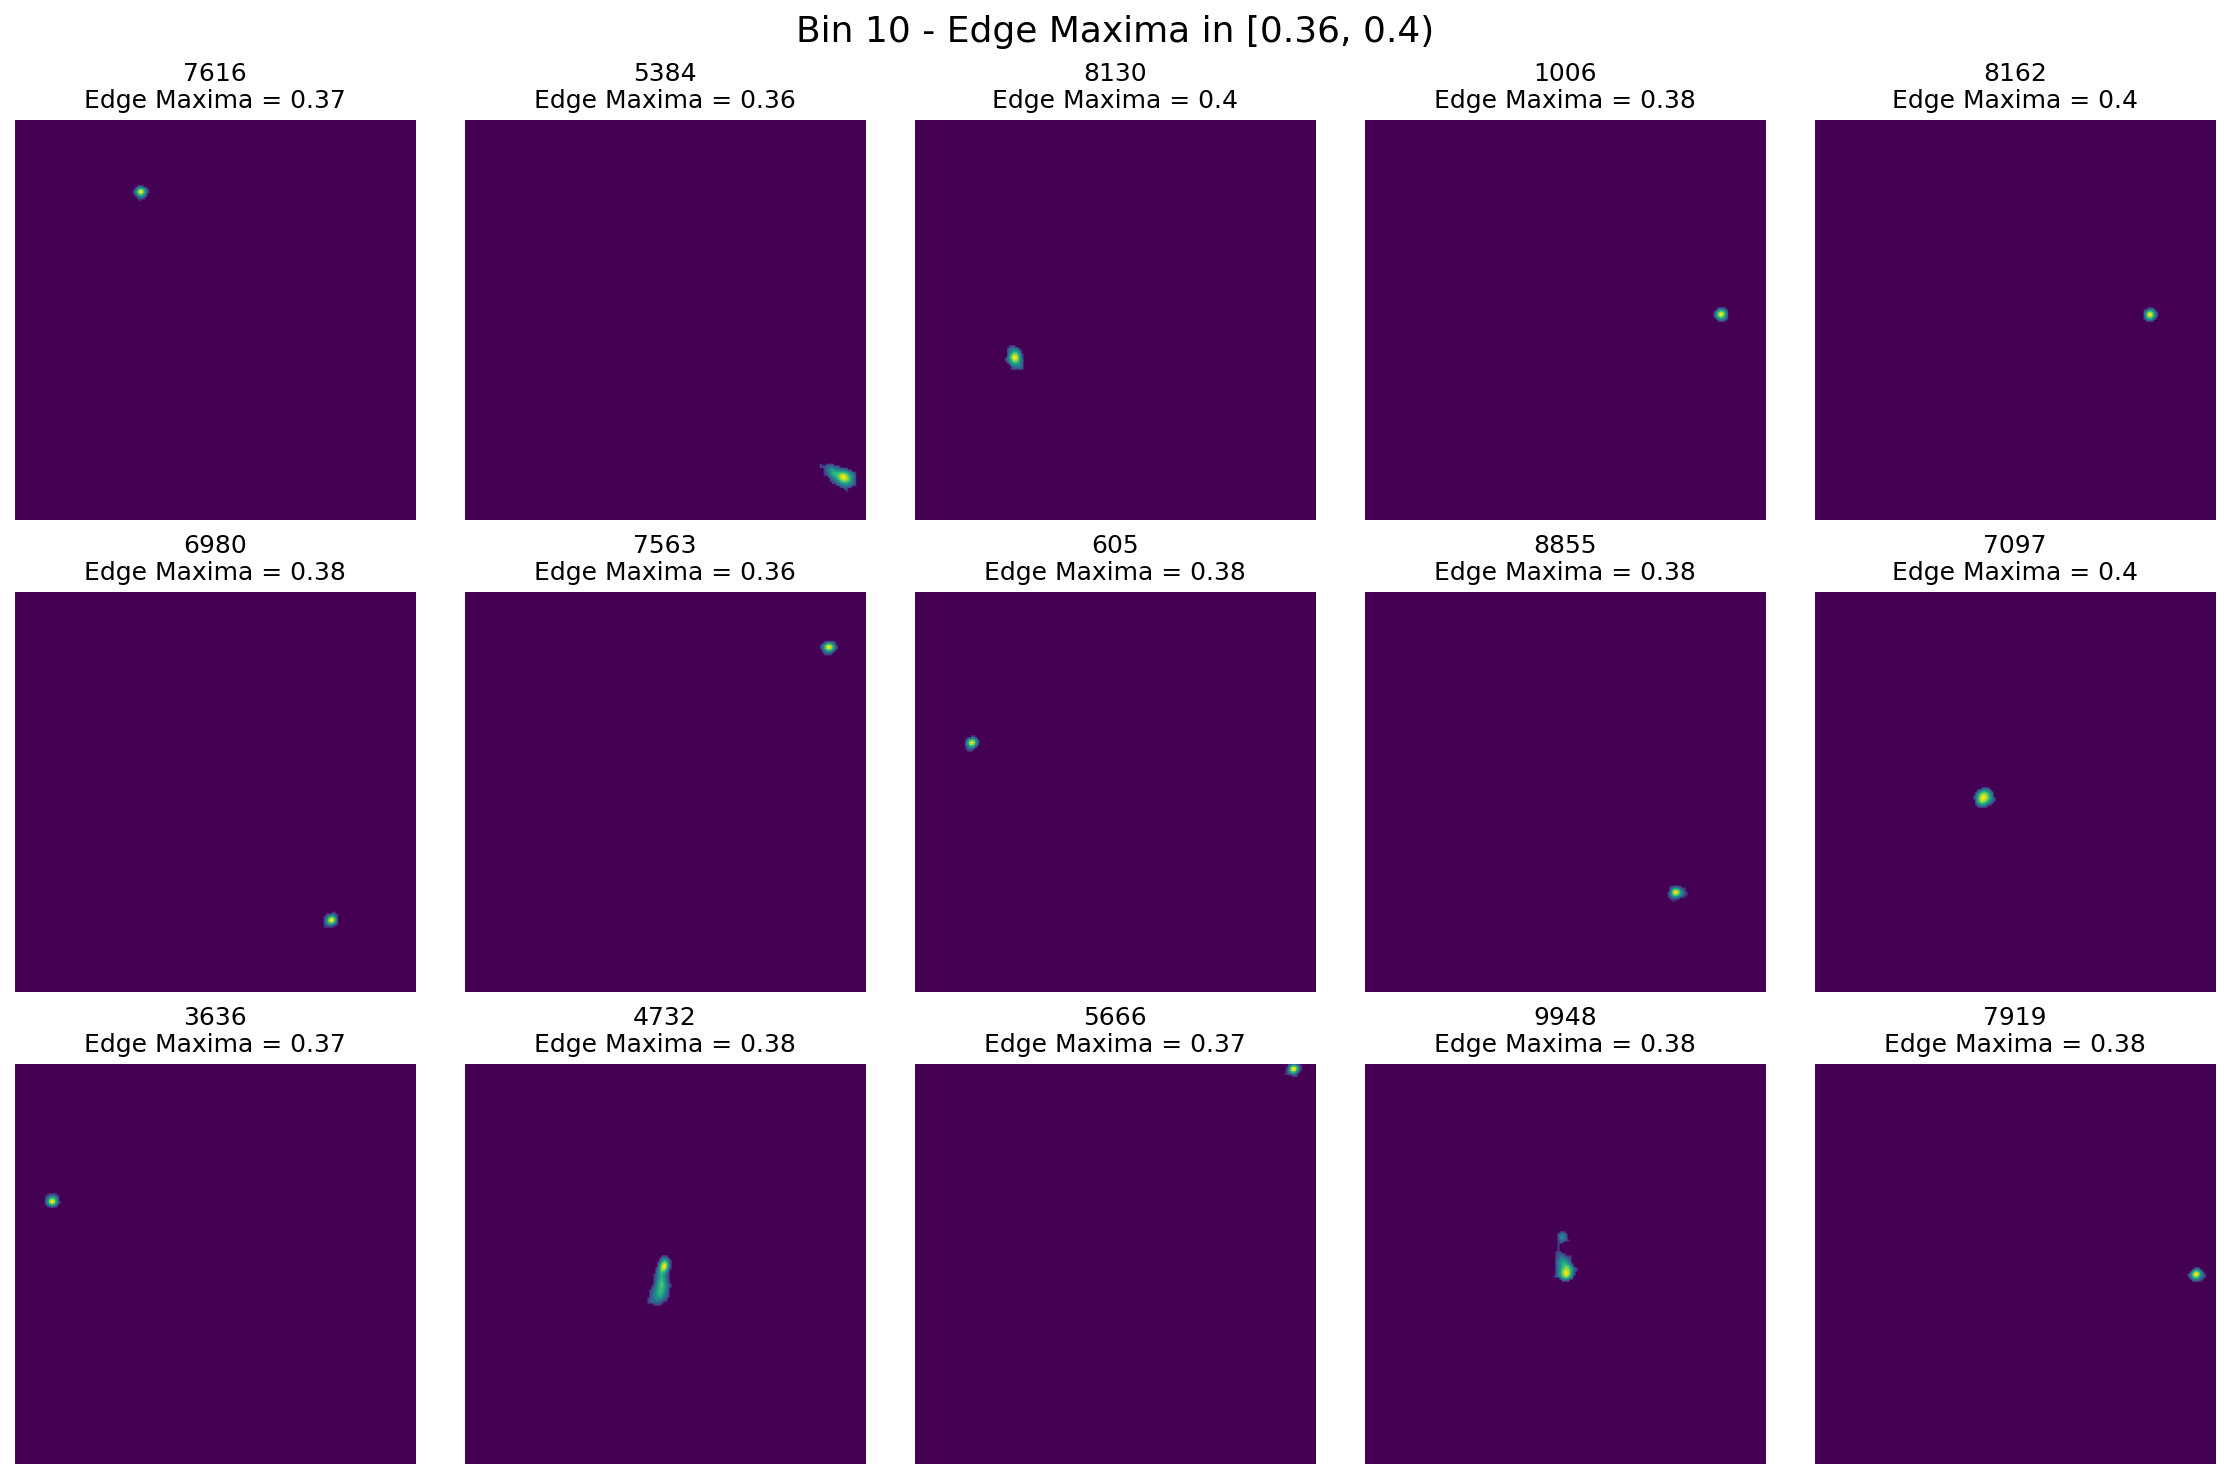

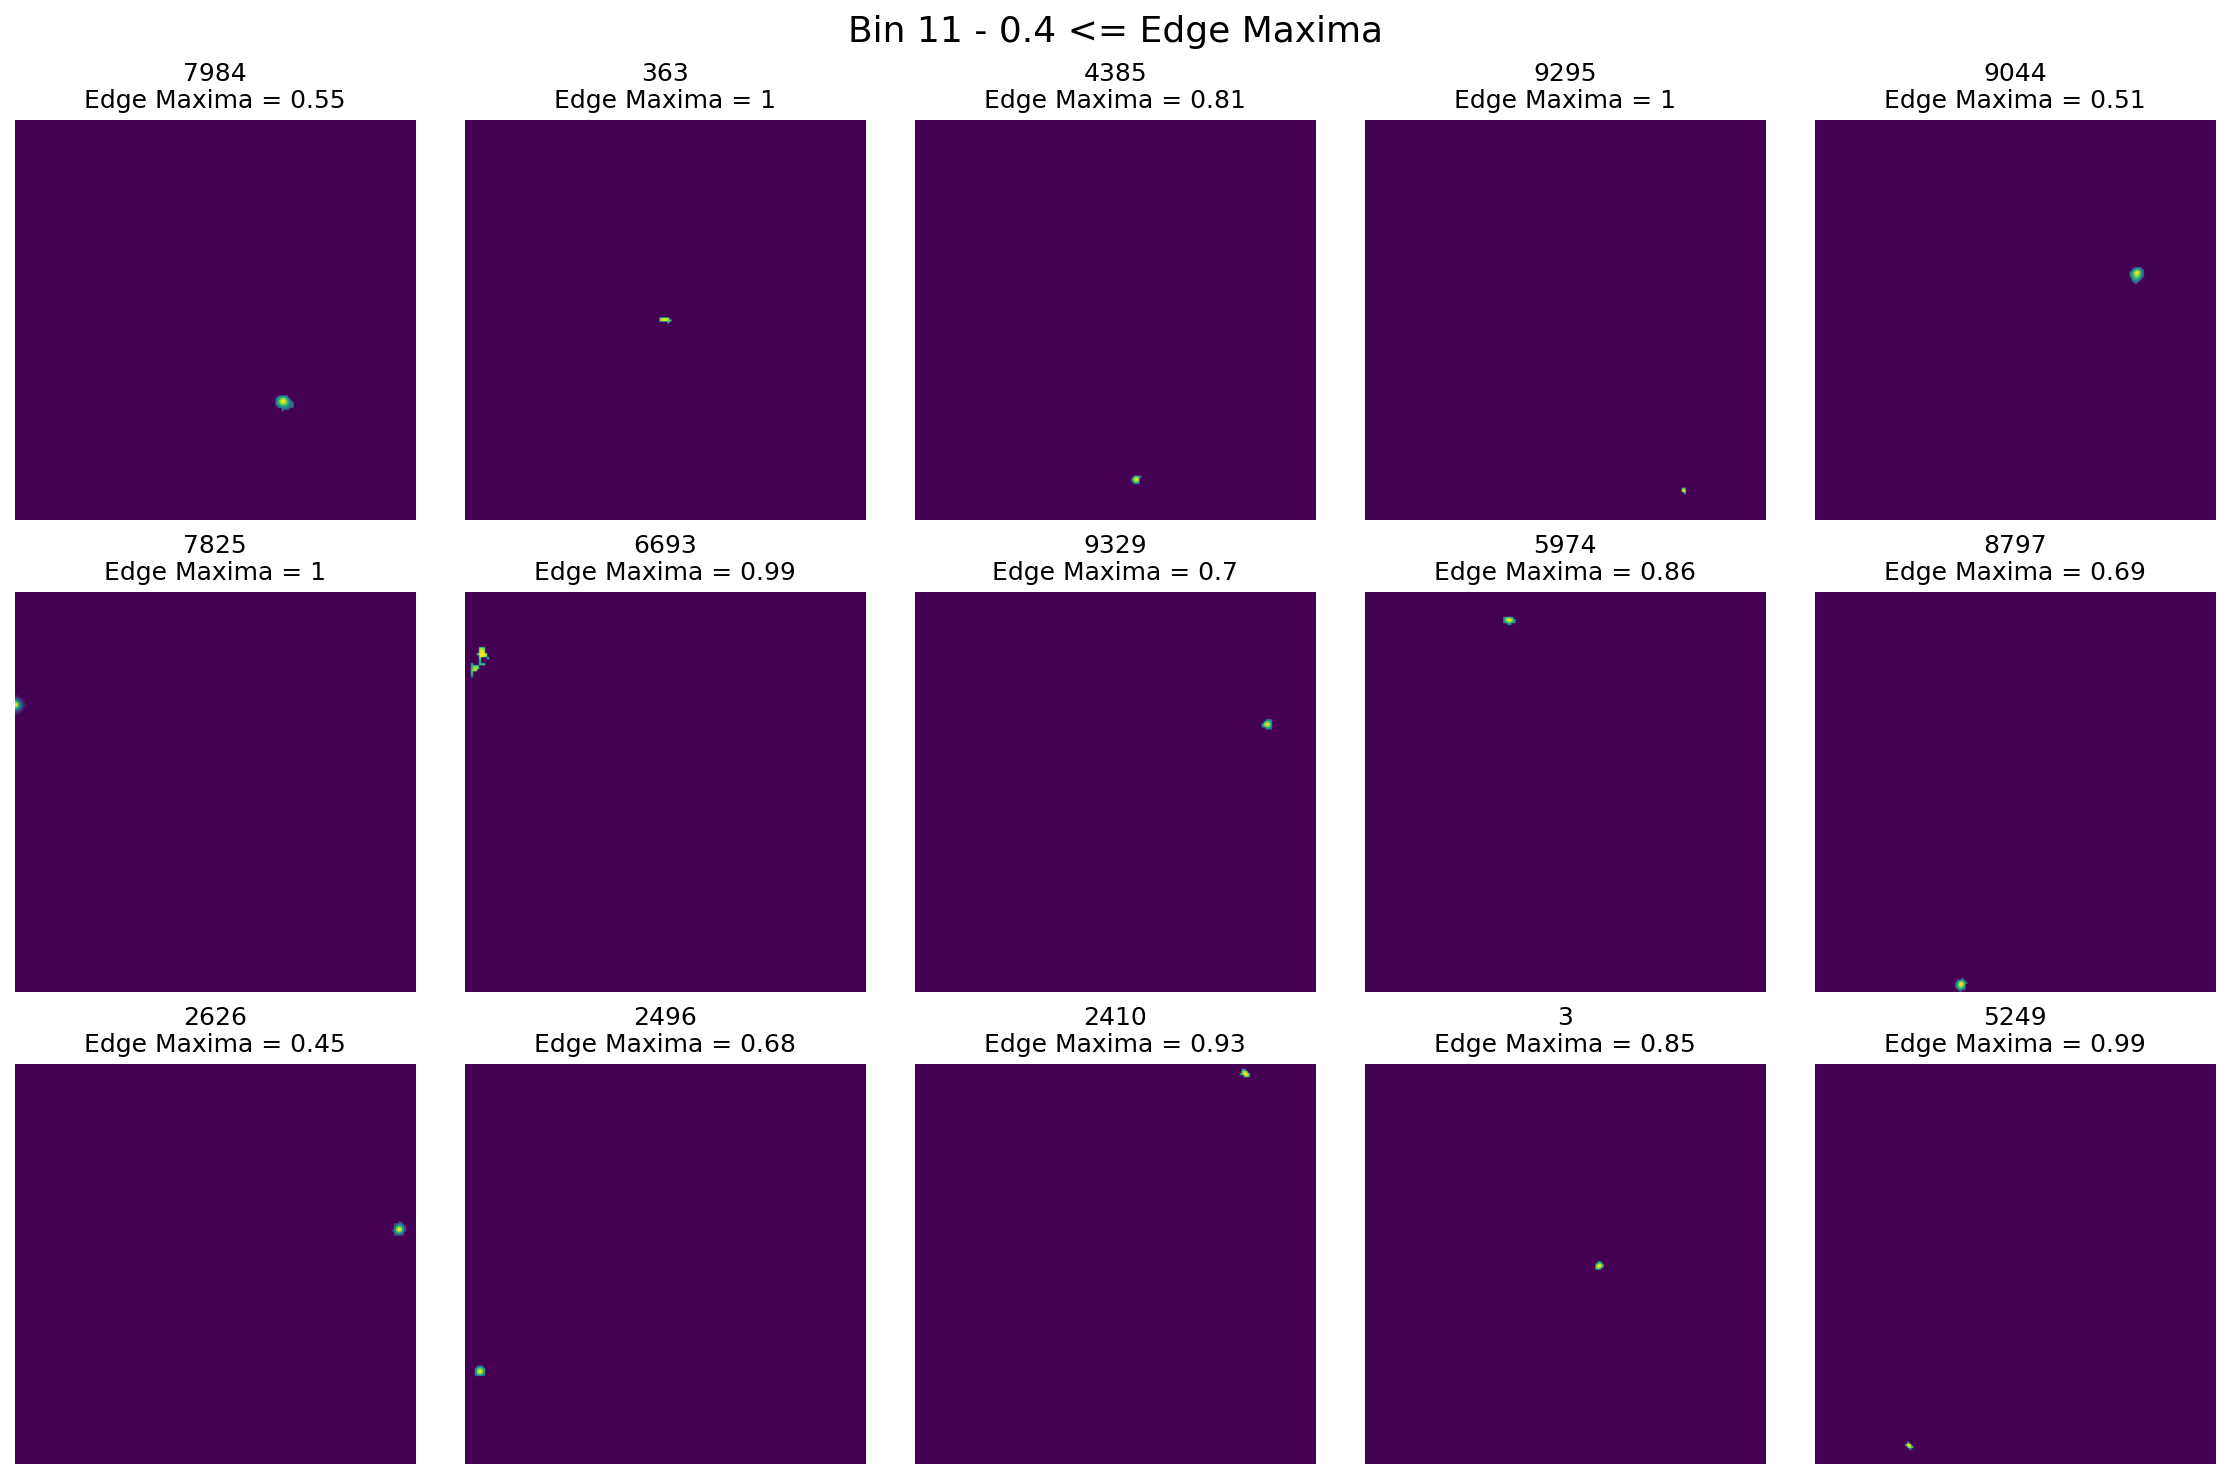

: 

In [21]:
# Edge-maxmax metric peek
from plotting.image_plots import metric_peek

metric_peek(
    edge_mx_single_sub.flatten(),
    np.linspace(0, 0.4, 11),
    source_signals_single_sub,
    metric_name="Edge Maxima",
    n_examples=15,
)

### Do selection

In [ ]:
from tqdm import tqdm

masks_edge_thr = np.copy(masks)  # [rms_selection_idxs]
empty_masks_flag = masks_edge_thr.sum(axis=(-1, -2)).flatten() == 0

# Remove masks for which the relative edge maximum is above a threshold
edge_max_threshold = 0.05
mask_flags = [edge_mx > edge_max_threshold for edge_mx in edge_mxs]
mask_cut = np.array([m.all() for m in mask_flags]) | empty_masks_flag
mask_pass = np.array([(~m).all() for m in mask_flags]) & ~empty_masks_flag

for i in tqdm(np.nonzero(~mask_pass & ~mask_cut)[0]):
    mask = masks_edge_thr[i]
    flag = mask_flags[i]
    labels, n = ndimage.label(mask, structure=np.ones((3, 3)))
    for lbl in range(1, n + 1):
        if flag[lbl - 1]:
            mask[labels == lbl] = 0

    masks_edge_thr[i] = mask

# idxs_edge_thr = rms_selection_idxs[~mask_cut]
idxs_edge_thr = np.nonzero(~mask_cut)[0]

In [ ]:
print(mask_cut.sum(), mask_pass.sum(),  mask_cut.sum() - mask_pass.sum(), len(idxs_edge_thr))
print((mask_cut & empty_masks_flag).sum(), empty_masks_flag.sum())

In [ ]:
imgs_sel = imgs[idxs_edge_thr]
imgs_sc_sel = imgs_sc[idxs_edge_thr]
masks_sel = masks_edge_thr[idxs_edge_thr]

masks_sel.shape, idxs_edge_thr.shape, masks_edge_thr.shape

In [ ]:
import h5py

with h5py.File(dset.path, "r+") as f:
    f["masks_edge_thr"][:] = masks_edge_thr

In [ ]:
# Plot some examples
ii = np.random.choice(len(idxs_edge_thr), 10, replace=False)

# ii = np.random.choice(np.nonzero(mask_cut)[0], 10, replace=False)

for i in ii:
    fig, axs = plt.subplots(1, 3, tight_layout=True, figsize=(18, 6))
    img = imgs[idxs_edge_thr[i]]
    mask = masks_edge_thr[idxs_edge_thr[i]]

    axs[0].imshow(img)
    axs[1].imshow(img * mask)
    axs[1].set_title(f"Edge Maxima: {edge_mxs[i]}")
    axs[2].imshow(img * (1 - mask))

    for ax in axs:
        ax.axis("off")
    plt.show()

In [ ]:
dset.save_selection(idxs_edge_thr, 'clean_mask', override=True)

In [ ]:
reload(data.datasets)
from data.datasets import LOFARDataset

dset_sel = LOFARDataset(
    paths.LOFAR_SUBSETS["200p"], img_size=200, selection='clean_mask',
    attributes=['masks_edge_thr'], train_mode=False
)

In [ ]:
dset_sel.set_train_mode(False)

In [ ]:
len(dset_sel)

In [ ]:
dset_sel.masks = dset_sel.masks_edge_thr
dset_sel.plot_image_grid(n_imgs=49, show_titles=True);

In [ ]:
from pprint import pprint

n_islands = count_islands(masks[idxs_edge_thr])
pprint({n: (n_islands == n).sum() for n in np.unique(n_islands)})

In [ ]:
idxs_edge_thr_single = idxs_edge_thr[n_islands == 1]
len(idxs_edge_thr_single)

In [ ]:
dset.save_selection(idxs_edge_thr_single, 'clean_mask_single_island', override=True)

In [ ]:
reload(seg)

imgs_selected = imgs[idxs_edge_thr][n_islands == 1]
masks_selected = masks_edge_thr[n_islands == 1]

circles = np.array([seg.get_circle(m) for m in tqdm(masks_selected)])

In [ ]:
radii = circles[:, 2]

# Cumulative distribution
radii_sorted = np.sort(radii)
plt.plot(radii_sorted, np.linspace(0, 1, len(radii)))

plt.grid(alpha=0.3)

In [ ]:
metric_peek(
    radii,
    np.linspace(40, 80, 6),
    imgs_selected * masks_selected,
)

In [ ]:
from matplotlib.patches import Circle

ii = np.random.choice(np.nonzero((radii > 80) & (radii <= 150))[0], 20, replace=False)

for i in ii:
    fig, axs = plt.subplots(1, 3, tight_layout=True, figsize=(18, 6))
    img = imgs_selected[i]
    mask = masks_selected[i]
    x, y, r = circles[i]

    axs[0].imshow(img)
    axs[1].imshow(img * mask)
    axs[1].add_patch(Circle((x, y), radius=r, color="r", fill=False, lw=1, alpha=0.5))
    axs[2].imshow(img * (1 - mask))

    for ax in axs:
        ax.axis("off")
    plt.show()

In [ ]:
mask_fraction = masks.sum(axis=(-1, -2)) / (masks.shape[-1] * masks.shape[-2])


fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(12, 6))

ax = axs[0]
ax.hist(mask_fraction, bins=10, label="Mask Fraction")
ax.set_yscale("log")

ax = axs[1]
sort_idxs = np.argsort(mask_fraction)
mask_fraction_sorted = mask_fraction[sort_idxs]
ax.plot(mask_fraction_sorted, np.linspace(0, 1, len(mask_fraction_sorted)))
ax.set_xscale("log")

for ax in axs:
    ax.grid(alpha=0.3)
    ax.legend()

In [ ]:
selection = (mask_fraction > 0.01) & (bg_rms / src_rms < 2e-2)
n = selection.sum()
print(f"Selected {n} images ({n / len(selection)*100:.2f}%)")

idxs = np.random.choice(np.where(selection)[0], 20, replace=False)

for i in idxs:
    fig, axs = plt.subplots(1, 3, tight_layout=True, figsize=(9, 3))

    ax = axs[0]
    ax.imshow(imgs[i])
    ax.axis("off")

    ax = axs[1]
    ax.imshow(sources_sc[i])
    ax.axis("off")

    ax = axs[2]
    ax.imshow(backgrounds_sc[i])
    ax.axis("off")

    plt.show()

## Source Coordinate Identification

In [ ]:
import utils.paths as paths
import data.datasets

reload(data.datasets)
from data.datasets import LOFARDataset

import data.segment as seg

reload(seg)

# Load Dataset
dset = LOFARDataset(
    paths.LOFAR_SUBSETS["200p"], img_size=200, load_catalog=True,
    selection='clean_mask_single_island', train_mode=False,
    attributes=['masks_edge_thr']
)
print(len(dset))

In [ ]:
import data.transforms as T

reload(T)
import numpy as np
import numpy.ma as ma

dset.masks = dset.masks_edge_thr

# Get data from dset
imgs = dset.data.numpy()
imgs_sc = T.max_scale_batch(dset.data).numpy()
masks = dset.masks.numpy()

# Apply masks (True indicates invalid data)
sources_sc = ma.masked_array(imgs_sc, mask=(masks == 0))
backgrounds_sc = ma.masked_array(imgs_sc, mask=(masks == 1))

In [ ]:
import pandas as pd
import numpy as np
from astropy.wcs import WCS
from tqdm import tqdm

cat = pd.read_csv(paths.LOFAR_RES_CAT)

def read_separations(df, source_id):
    # Two series with same index
    col = df[source_id].drop(source_id)
    row = df.loc[source_id].drop(source_id)

    # Combine the two series
    comb = pd.concat([col[pd.notna(col)], row[pd.notna(row)]])
    return comb


def contaminating_sources(idx, dset):
    mosaic_id = dset.catalog.Mosaic_ID.values[idx]
    source_id = dset.names[idx]
    max_sep = 1.5 * dset.data.shape[-1] // 2 / 3600

    matches = []

    for coord in ["ra", "dec"]:
        df = pd.read_csv(
            paths.LOFAR_DATA_PARENT
            / f"source_separations/{mosaic_id}/source_delta_{coord}_{mosaic_id}.csv",
            index_col=0,
        )
        sep = read_separations(df, source_id)
        matches.append(sep[np.abs(sep.values) < max_sep].index.tolist())

    # Remove duplicates from output
    out = [src for src in matches[0] if src in matches[1]]
    return out


def get_coordinates(src_names, catalog=cat):
    out = []
    for name in src_names:
        src = catalog[catalog["Source_Name"] == name].iloc[0]
        if pd.notna(src["optRA"]):
            ra, dec = src["optRA"], src["optDec"]
        else:
            ra, dec = src["RA"], src["DEC"]
        out.append([ra, dec])
    return np.array(out)


def create_wcs(i, dset):
    center = get_coordinates([dset.names[i]])[0]
    cdelt = 1.5 / 3600
    wcs_params = {
        "CTYPE1": "RA---SIN",  # RA in TAN projection
        "CTYPE2": "DEC--SIN",  # Dec in TAN projection
        "CRVAL1": center[0],  # RA at reference pixel
        "CRVAL2": center[1],  # Dec at reference pixel
        "CUNIT1": "deg",
        "CUNIT2": "deg",
        "CRPIX1": 100,  # Reference pixel X (center of the image)
        "CRPIX2": 100,  # Reference pixel Y (center of the image)
        "CDELT1": -cdelt,  # Pixel scale in RA (degrees/pixel)
        "CDELT2": cdelt,  # Pixel scale in Dec (degrees/pixel)
        "RADESYS": "ICRS",
    }
    w = WCS(naxis=2)
    w.wcs.crpix = [wcs_params["CRPIX1"], wcs_params["CRPIX2"]]
    w.wcs.cdelt = np.array([wcs_params["CDELT1"], wcs_params["CDELT2"]])
    w.wcs.crval = [wcs_params["CRVAL1"], wcs_params["CRVAL2"]]
    w.wcs.ctype = [wcs_params["CTYPE1"], wcs_params["CTYPE2"]]
    w.wcs.radesys = wcs_params["RADESYS"]
    w.wcs.cunit = [wcs_params["CUNIT1"], wcs_params["CUNIT2"]]
    return w

In [ ]:
# Sanity Check
ii = np.random.choice(len(dset), 10, replace=False)

for i in ii:
    img = dset.data[i]
    mask = dset.masks[i]
    sources = contaminating_sources(i, dset)
    coords = get_coordinates(sources)
    center = get_coordinates([dset.names[i]])[0]
    wcs = create_wcs(i, dset)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5), subplot_kw={"projection": wcs})

    axs[0].imshow(img, origin="lower")
    axs[1].imshow(img * (1 - mask), origin="lower")

    for ax in axs:
        ax.contour(mask, levels=[0.5], colors="white", alpha=0.5)
        ax.scatter(
            center[0],
            center[1],
            transform=ax.get_transform("world"),
            s=30,
            color="orange",
            marker="x",
            alpha=0.5,
        )
        if len(coords) > 0:
            ax.scatter(
                coords[:, 0],
                coords[:, 1],
                transform=ax.get_transform("world"),
                s=30,
                color="red",
                marker="x",
                alpha=0.5,
            )

    fig.show()

In [ ]:
from tqdm import tqdm
from scipy.ndimage import binary_dilation
import concurrent.futures
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor


def source_profile(i, dilate=0):
    mask = masks[i]
    if dilate > 0:
        mask = binary_dilation(mask, iterations=dilate)
    wcs = create_wcs(i, dset)
    cont_src = contaminating_sources(i, dset)
    cont_coords = get_coordinates(cont_src)
    cont_locs = np.round(wcs.all_world2pix(cont_coords, 0)).astype(int)
    guests_on_mask = []
    for j in range(len(cont_src)):
        if mask[cont_locs[j, 1], cont_locs[j, 0]] == 1:
            guests_on_mask.append(cont_src[j])
    
    host_on_mask = mask[100, 100].astype(bool)
    return i, host_on_mask, guests_on_mask


def get_profiles(dataset, dilate=0):
    num_sources = len(dataset)
    results = []

    with ProcessPoolExecutor(max_workers=16) as executor:
        futures = [executor.submit(source_profile, i, dilate=dilate) for i in range(num_sources)]
        for future in tqdm(concurrent.futures.as_completed(futures), total=num_sources):
            results.append(future.result())

    return results

def plot_image_with_sources(i, dset):
    img = dset.data[i]
    mask = dset.masks[i]
    sources = contaminating_sources(i, dset)
    coords = get_coordinates(sources)
    center = get_coordinates([dset.names[i]])[0]
    wcs = create_wcs(i, dset)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5), subplot_kw={"projection": wcs})

    axs[0].imshow(img, origin="lower")
    axs[1].imshow(img * (1 - mask), origin="lower")

    for ax in axs:
        ax.contour(mask, levels=[0.5], colors="white", alpha=0.5)
        ax.scatter(
            center[0],
            center[1],
            transform=ax.get_transform("world"),
            s=30,
            color="orange",
            marker="x",
            alpha=0.5,
        )
        if len(coords) > 0:
            ax.scatter(
                coords[:, 0],
                coords[:, 1],
                transform=ax.get_transform("world"),
                s=30,
                color="red",
                marker="x",
                alpha=0.5,
            )

    return fig, axs


In [ ]:
profiles = get_profiles(dset)

In [ ]:
# Profiles are tuples of (index, host_on_mask, guests_on_mask), 
# here we extract the information into separate arrays and sort by index
profile_idxs = np.array([p[0] for p in profiles])
sort_idxs = np.argsort(profile_idxs)
hosts = np.array([p[1] for p in profiles])[sort_idxs]
guests = [profiles[i][2] for i in sort_idxs]

n_guests = np.array([len(g) for g in guests])
src_on_isl = n_guests + hosts.astype(int)

In [ ]:
np.argwhere(src_on_isl > 1).shape

In [ ]:
# Sanity check
ii = np.random.choice(np.argwhere(hosts).flatten(), 10, replace=False)

for i in ii:

    img = dset.data[i]
    mask = dset.masks[i]
    host, gg = hosts[i], guests[i]
    wcs = create_wcs(i, dset)

    cont_mask = np.zeros_like(mask)
    cont_src = contaminating_sources(i, dset)
    cont_coords = get_coordinates(cont_src)
    if len(cont_coords) > 0:
        cont_locs = np.round(wcs.all_world2pix(cont_coords, 0)).astype(int)
        cont_mask[cont_locs[:, 1], cont_locs[:, 0]] = 1
    
    fig, axs = plt.subplots(1, 2, figsize=(16, 8), subplot_kw={'projection': wcs})

    ax = axs[0]
    # Plot image with mask
    ax.imshow(img, origin='lower')
    ax.contour(mask, levels=[0.5], colors='w', linewidths=0.5)

    # Scatter plot of contaminating sources
    if len(cont_coords) > 0:
        ax.scatter(*wcs.all_world2pix(cont_coords, 0).T, marker='x', color='r', s=100)

    # Mark host
    coords = get_coordinates([dset.names[i]])[0]
    ax.scatter(*wcs.all_world2pix([coords], 0).T, marker='x', color='orange')

    ax.set_title(f"Index {i} - {dset.names[i]}\nHost on mask: {host}\nGuests on mask: {gg}")

    ax = axs[1]
    # plt.imshow(cont_mask, origin='lower')
    plt.imshow(img * (1 - mask), origin='lower')
    
    plt.show()




In [ ]:
n, c = np.unique(n_guests, return_counts=True)
print("Guests on island:")
print([f"{n[i]}: {c[i]}" for i in range(len(n))])

n, c = np.unique(src_on_isl, return_counts=True)
print("Total sources on island:")
print([f"{n[i]}: {c[i]}" for i in range(len(n))])

print("Number of multiples:")
print(np.sum(src_on_isl > 1))

In [ ]:
i_ghosts = np.argwhere(src_on_isl == 0).flatten()
i_singles = np.argwhere(src_on_isl == 1).flatten()
i_guest_singles = np.argwhere((n_guests == 1) & (~hosts)).flatten()

In [ ]:
# Sanity Check
for i in np.random.choice(i_guest_singles, 10, replace=False):
    fig, _ = plot_image_with_sources(i, dset)
    fig.show()


### Catalogize True Singles

In [ ]:
# The names of the singles are either the host or the guest
true_singles = [
    dset.names[i] if hosts[i] else guests[i][0] for i in i_singles
]
unique_true_singles, unique_inverse = np.unique(true_singles, return_inverse=True)

# Indices of all images in the dset where the unique singles appear 
i_appearances_single = [
    i_singles[np.nonzero(unique_inverse == i)[0]] for i in range(len(unique_true_singles))
]

# Boolean flag indicating if the source is listed in the catalog
is_listed = np.array([s in set(dset.names) for s in tqdm(unique_true_singles)])

# See if the source is masked on its home image, if existing
home_app = np.array([
    hosts[np.argwhere(dset.names == name).flatten()[0]] if is_listed[j] else False
    for j, name in tqdm(enumerate(unique_true_singles), total=len(unique_true_singles))
])

In [ ]:
true_singles_df = pd.DataFrame({
    "Source": unique_true_singles,
    "Listed": is_listed,
    "Home_Appearance": home_app,
    "Appearances": i_appearances_single
})

In [ ]:
corresponding_images = np.full_like(true_singles_df.Source.values, -1, dtype=int)

# For Normies (Listed & Home App.), take the home image, i.e. index where the source is listed
normie_flag = is_listed & home_app
corresponding_images[normie_flag] = [
    np.argwhere(dset.names == name).flatten()[0] for name in tqdm(true_singles_df.Source.values[normie_flag])
]

# For all others, take the one that is most centered 
from skimage.measure import centroid

for k in np.nonzero(~normie_flag)[0]:
    idxs = true_singles_df.Appearances.values[k]
    i_center = np.argmin([np.linalg.norm(centroid(masks[i]) - 100) for i in idxs])
    corresponding_images[k] = idxs[i_center]

true_singles_df["Corresponding_Image"] = corresponding_images

In [ ]:
# For the selected images, check if any mask touches the image edge
def touches_edge(mask):
    return np.any([mask[0, :], mask[-1, :], mask[:, 0], mask[:, -1]])

edge_touch = np.array([
    np.any(touches_edge(dset.masks[i])) for i in tqdm(true_singles_df['Corresponding_Image'].values)
])

df_edge_touch = true_singles_df[edge_touch]
true_singles_df = true_singles_df[~edge_touch]

In [ ]:
len(true_singles_df), len(df_edge_touch)

In [ ]:
# Plot some examples
for i in np.random.choice(df_edge_touch['Corresponding_Image'].values, 10, replace=False):
    fig, _ = plot_image_with_sources(i, dset)
    fig.show()

In [ ]:
from data.segment import get_circle

def center_source(img, mask):
    x, y, r = get_circle(mask)

    # Return new image and mask, translated so that x, y is at center
    img_c = np.zeros_like(img)
    mask_c = np.zeros_like(mask)
    mask_coords = np.flip(np.argwhere(mask), axis=1)
    mask_coords_c = mask_coords - [x, y] + 100
    mask_c[mask_coords_c[:, 1], mask_coords_c[:, 0]] = 1
    img_c[mask_coords_c[:, 1], mask_coords_c[:, 0]] = img[mask_coords[:, 1], mask_coords[:, 0]]
    return img_c, mask_c, r

In [ ]:
center_srcs = [center_source(imgs_sc[i], masks[i]) for i in tqdm(true_singles_df['Corresponding_Image'].values)]
true_singles_df['Host_Source'] = dset.names[true_singles_df['Corresponding_Image'].values]

In [ ]:
import data.transforms as T

proto_imgs = np.array([c[0] for c in center_srcs])
proto_imgs = T.max_scale_batch(model_imgs)
proto_masks = np.array([c[1] for c in center_srcs])
proto_radii = np.array([c[2] for c in center_srcs])

true_singles_df['Model_Radius'] = proto_radii
true_singles_df['Host_Source'] = dset.names[true_singles_df['Corresponding_Image'].values]
true_singles_df.reset_index(drop=True, inplace=True)

In [ ]:
true_singles_df

In [ ]:
np.argwhere(true_singles_df.Model_Radius > 60).flatten()

In [ ]:
from matplotlib.patches import Circle
# Plot random examples

# ii = np.random.choice(np.argwhere(true_singles_df.Model_Radius > 60).flatten(), 10, replace=False)
ii = np.random.choice(len(true_singles_df), 10, replace=False)

for i in ii:
    fig, axs = plt.subplots(1, 2, figsize=(6, 3), tight_layout=True)
    proto_img = proto_imgs[i]
    orig_img = imgs[true_singles_df['Corresponding_Image'].values[i]]
    orig_mask = masks[true_singles_df['Corresponding_Image'].values[i]]
    x, y, r = get_circle(orig_mask)
    
    axs[0].imshow(orig_img)
    axs[0].contour(orig_mask, levels=[0.5], colors='white', alpha=0.9, linewidths=0.5)
    axs[0].add_patch(Circle((x, y), r, color='r', fill=False, lw=1, alpha=0.5))
    axs[0].scatter(100, 100, color='orange', marker='x', s=10, lw=0.5)
    axs[0].scatter(x, y, color='red', marker='x', s=10, lw=0.5)

    axs[1].imshow(proto_img)
    axs[1].add_patch(Circle((100, 100), r, color='r', fill=False, lw=1, alpha=0.5))
    axs[1].scatter(100, 100, color='orange', marker='x', s=10, lw=0.5)


    for ax in axs:
        ax.axis("off")

    plt.show()



In [ ]:
# Cumulative distribution
plt.plot(np.sort(model_radii), np.linspace(0, 1, len(model_radii)))
# plt.yscale('log')
plt.grid(alpha=0.3)

In [ ]:
# Metric peek at radii
import plotting.image_plots
reload(plotting.image_plots)
from plotting.image_plots import metric_peek

metric_peek(
    model_radii,
    np.linspace(0, 80, 9),
    model_imgs,
    masks=model_masks,
)

In [ ]:
proto_imgs = np.clip(proto_imgs, 0, 1)

In [ ]:
import h5py

subset_file = paths.LOFAR_DATA_PARENT / 'subsets/LOFAR_prototypes.hdf5'

with h5py.File(subset_file, "w") as f:
        img_dataset = f.create_dataset("images", data=proto_imgs)
        img_dataset.attrs["original_file"] = str(dset.path)
        
        f.create_dataset("masks", data=proto_masks)
        f.create_dataset("original_images", data=imgs[true_singles_df['Corresponding_Image'].values])
        f.create_dataset("original_masks", data=masks[true_singles_df['Corresponding_Image'].values])

In [ ]:
true_singles_df.reset_index(drop=True, inplace=True)
true_singles_df.to_hdf(subset_file, key="mask_metadata")

In [ ]:
# Create subset of resolved sources catalog
lofar_res = pd.read_csv(paths.LOFAR_RES_CAT)
lofar_res = lofar_res[lofar_res["Source_Name"].isin(true_singles_df["Source"].values)]

In [ ]:
lofar_res.to_hdf(subset_file, key="catalog")

In [ ]:
from data.segment import get_circle
from matplotlib.patches import Circle

stranger_flag = ~true_singles_df['Home Appearance']

for i in np.random.choice(true_singles_df['Corresponding Image'].values, 10, replace=False):
    img = dset.data[i]
    mask = masks[i]
    x, y, r = get_circle(mask)

    fig, axs = plt.subplots(1, 3, figsize=(15, 5), tight_layout=True)

    ax = axs[0]
    ax.imshow(img, origin='lower')
    ax.contour(mask, levels=[0.5], colors='w')
    ax.add_patch(Circle([x, y], r, color='r', fill=False))

    ax = axs[1]
    img_c = np.zeros_like(img)
    mask_c = np.zeros_like(mask)
    mask_coords = np.flip(np.argwhere(mask), axis=1)
    mask_coords_c = mask_coords - [x, y] + 100
    mask_c[mask_coords_c[:, 1], mask_coords_c[:, 0]] = 1
    img_c[mask_coords_c[:, 1], mask_coords_c[:, 0]] = img[mask_coords[:, 1], mask_coords[:, 0]]
    ax.imshow(img_c, origin='lower')

    ax = axs[2]
    ax.imshow(img * (1 - mask), origin='lower')
    for ax in axs:
        ax.axis('off')


#### Look at weird flags (listed but no host app.)

In [ ]:
weird_flag = is_listed & ~home_app
weird_flag.sum()

In [ ]:
weird_flag = is_listed & ~home_app
weird_idxs = np.nonzero(np.isin(dset.names, true_singles_df.Source[weird_flag]))[0]

for i in weird_idxs:
    fig, axs = plot_image_with_sources(i, dset)
    for ax in axs.flatten():
        ax.contour(binary_dilation(masks[i], iterations=10), levels=[0.5], colors='orange', linewidths=0.5, alpha=0.5)
    name = dset.names[i]
    fig.suptitle(f"Original: Index {i} - {name}")

    i_appearances = i_appearances_single[np.argwhere(unique_true_singles == name).flatten()[0]]
    for j in i_appearances:
        fig, axs = plot_image_with_sources(j, dset)
        for ax in axs.flatten():
            ax.contour(binary_dilation(masks[j], iterations=10), levels=[0.5], colors='orange', linewidths=0.5, alpha=0.5)
        fig.suptitle(f"Appearance: Index {j} - {dset.names[j]}")
        fig.show()

In [ ]:
from data.cutouts import cutout_from_catalog

def quick_cutout(name):
    ind = cat.loc[cat["Source_Name"] == name].index[0]
    data, has_nan = cutout_from_catalog(cat, ind, size_px=200)
    return data, has_nan

i_listed = np.argwhere(is_listed).flatten()

for i in np.random.choice(i_listed, 10, replace=False):
    data, has_nan = quick_cutout(unique_true_singles[i])
    i_appearances = i_appearances_single[i]

    fig, ax = plt.subplots(1, 1)
    ax.imshow(data, origin='lower')
    fig.suptitle(f"{unique_true_singles[i]} Cutout")
    ax.axis('off')
    fig.show()

    for j in i_appearances:
        fig, axs = plot_image_with_sources(j, dset)
        fig.suptitle(f"Index {j} - {dset.names[j]}")
        fig.show()

In [ ]:
# For every source, count how often it appears on an island as a guest
guests_flat = [g for sublist in guests for g in sublist]
guest_src, guest_counts = np.unique(guests_flat, return_counts=True)

In [ ]:
guest_appearances = {
    n: 0 for n in dset.names
}
guest_appearances.update(dict(zip(guest_src, guest_counts)))

In [ ]:
import copy

total_appearnaces = { n: 0 for n in list(set(list(dset.names) + list(guest_src))) }
                     
for n in tqdm(total_appearnaces.keys()):
    total_appearnaces[n] = guest_appearances[n]
    if n in dset.names:
        total_appearnaces[n] += int(hosts[dset.names == n][0])

In [ ]:
max(total_appearnaces.values())

In [ ]:
plt.hist(total_appearnaces.values(), bins=np.linspace(0, 7, 8)-0.5)

In [ ]:
(np.array(list(total_appearnaces.values())) > 0).sum()

In [ ]:
for i in tqdm(range(100)):
    try:
        profle = source_profile(i)
    except Exception as e:
        print(e)
        print(i)
        break

In [ ]:
(dset.names == dset.catalog.Source_Name.values).all()

In [ ]:
(dset.names[20] == cat.Source_Name).any()

In [ ]:
src = contaminating_sources(20, dset)
print(src)
for s in src:
    print(cat[cat.Source_Name == s])

In [ ]:
i = 0

wcs = create_wcs(i, dset)
cont_src = contaminating_sources(i, dset)
cont_coords = get_coordinates(cont_src)
cont_locs = np.round(wcs.all_world2pix(cont_coords, 0)).astype(int)
cont_mask = np.zeros_like(masks[i])
cont_mask[cont_locs[:, 1], cont_locs[:, 0]] = 1

fig, axs = plt.subplots(1, 2, figsize=(10, 5), subplot_kw={"projection": wcs})

axs[0].imshow(imgs_sc[i], origin="lower")
axs[0].contour(masks[i], levels=[0.5], colors="cyan", linewidths=0.5, alpha=0.5)

axs[1].imshow(masks[i], origin="lower")
axs[1].scatter(*cont_coords.T, transform=axs[0].get_transform("world"), color="r")

In [ ]:
n_isl = count_islands(masks)

In [ ]:
n, c = np.unique(n_isl, return_counts=True)
print([f"{n[i]}: {c[i]}" for i in range(len(n))])

In [ ]:
ii = np.argwhere(n_isl == 2).flatten()

for i in ii:
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(imgs_sc[i], origin="lower")
    axs[0].contour(masks[i], levels=[0.5], colors="cyan", linewidths=0.5, alpha=0.5)

    axs[1].imshow(imgs_sc[i] * (1 - masks[i]), origin="lower")

### Catalogize Ghost Sources

In [ ]:
island_coords = [
    create_wcs(i, dset).all_pix2world(np.transpose(np.nonzero(masks[i])), 0) for i in tqdm(i_ghosts)
]

In [ ]:
from skimage.measure import centroid

center_dist = np.array([
    np.linalg.norm(centroid(masks[i]) - [100, 100]) for i in tqdm(i_ghosts)
])

In [ ]:
import math
from itertools import combinations

def overlap(k, l):
    # k,l are indices corresponding to ghosts
    i = i_ghosts[k]
    wcs = create_wcs(i, dset)
    mask_i_coords = np.transpose(np.nonzero(masks[i]))
    mask_j_coords = island_coords[l]
    mask_j_transf = wcs.all_world2pix(mask_j_coords, 0)
    # Keep only coordinates where both values are between 0 and 200
    mask_j_transf = mask_j_transf[np.all(mask_j_transf >= 0, axis=1) & np.all(mask_j_transf < 200, axis=1)].astype(int)
    if len(mask_j_transf) == 0:
        return k, l, False
    return k, l, np.any(np.all(mask_i_coords == mask_j_transf[:, None], axis=-1))

def pair_wise_overlap_parallel():
    # Calculate the pair-wise overlap between all ghost islands in parallel.
    # This is done in parallel to speed up the process.
    # The results are stored in a dictionary with the keys being the indices of the ghosts
    # and the values being lists of indices of overlapping ghosts.

    overlap_martix = np.zeros((len(i_ghosts), len(i_ghosts)), dtype=bool)
    # Diagonal is always true
    np.fill_diagonal(overlap_martix, True)

    with ProcessPoolExecutor(max_workers=16) as executor:
        futures = [
            executor.submit(overlap, k, l) for k, l in combinations(range(len(i_ghosts)), 2)
        ]
        for future in tqdm(concurrent.futures.as_completed(futures), total=math.comb(len(i_ghosts), 2)):
            k, l, ov = future.result()
            overlap_martix[k, l] = ov
            overlap_martix[l, k] = ov
    return overlap_martix

In [ ]:
[overlap(0, j) for j in tqdm(range(len(i_ghosts)))]

In [ ]:
print('a')

In [ ]:
overlap_matrix = pair_wise_overlap_parallel()

In [ ]:
l, k = 15, 15

i = i_ghosts[k]
wcs = create_wcs(i, dset)
mask_i_coords = np.transpose(np.nonzero(masks[i]))

fig, axs = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)

ax = axs[0]
ax.imshow(masks[i], origin="lower")
ax.scatter(*reversed(mask_i_coords.T), color="r", marker=".", s=0.25)

ax = axs[1]
ax.imshow(masks[i], origin="lower")

mask_j_coords = island_coords[l]
mask_j_transf = wcs.all_world2pix(mask_j_coords, 0)

ax.scatter(*reversed(mask_j_transf.T), color="r", marker=".", s=0.25)

for ax in axs:
    ax.axis('off')

In [ ]:
np.flip(mask_j_coords).shape

In [ ]:
k, l = 2, 2

i = i_ghosts[k]
j = i_ghosts[l]
wcs = create_wcs(i, dset)
mask_i_coords = np.transpose(np.nonzero(masks[i]))
mask_j_coords = island_coords[l]
mask_j_transf = wcs.all_world2pix(mask_j_coords, 0)
print(mask_j_transf.T)

# Keep only coordinates where both values are between 0 and 200
# mask_j_transf = mask_j_transf[np.all(mask_j_transf >= 0, axis=1) & np.all(mask_j_transf < 200, axis=1)].astype(int)

fig, axs = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)

ax = axs[0]
ax.imshow(masks[i], origin="lower")
ax.scatter(*reversed(mask_i_coords.T), color="r", marker=".", s=0.25)

ax = axs[1]
ax.imshow(masks[j], origin="lower")
ax.scatter(*reversed(mask_j_transf.T), color="r", marker=".", s=0.25)

for ax in axs:
    ax.axis('off')

In [ ]:
from copy import deepcopy
import warnings

# Loop through ghost sources:
filtered_ghost_sources = np.copy(i_ghosts).tolist()
overlap_dict = {}
pbar = tqdm(i_ghosts)

k = 0
while k < len(filtered_ghost_sources):
    # Get source i
    i = filtered_ghost_sources[k]
    wcs = create_wcs(i, dset)
    overlaps = []
    mask_i_coords = np.transpose(np.nonzero(masks[i]))

    # Loop through filtered list
    for j in filtered_ghost_sources:

        # Skip self
        if i == j:
            continue

        # Transform mask coordinates to image i
        mask_j_transf = wcs.all_world2pix(island_coords[np.nonzero(i_ghosts == j)[0][0]], 0)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            mask_j_transf = np.round(mask_j_transf).astype(int)

        # See if masks overlap: Check for any equal coordinate pairs
        if np.any(np.all(mask_i_coords[:, None] == mask_j_transf, axis=-1)):
            overlaps.append(j)


    # Keep the one with smallest distance to center, remove all others
    # from the filtered list
    if len(overlaps) > 0:
        dists = center_dist[overlaps + [i]]
        duplicates = deepcopy(overlaps)
        duplicates.pop(np.argmin(dists))
        for d in duplicates:
            filtered_ghost_sources.remove(d)

    overlap_dict[i] = overlaps

    # Update progress bar
    pbar.update(1 + len(overlaps))
    k += 1

In [ ]:
pbar.close()

## Background Noise Statistics

In [ ]:
# Calculate statistics
bg_mean = backgrounds_sc.mean(axis=(-1, -2))
bg_std = backgrounds_sc.std(axis=(-1, -2))
bg_rms = np.sqrt((backgrounds_sc**2).mean(axis=(-1, -2)))

In [ ]:
src_rms = np.sqrt((sources_sc**2).mean(axis=(-1, -2)))

In [ ]:
bg_mean_sel = bg_mean[idxs_edge_thr]
bg_std_sel = bg_std[idxs_edge_thr]
bg_rms_sel = bg_rms[idxs_edge_thr]
src_rms_sel = src_rms[idxs_edge_thr]

In [ ]:
fig, axs = plt.subplots(2, 3, tight_layout=True, figsize=(18, 10))

ax = axs[0][0]
ax.hist(bg_rms, bins=10, label="All")
ax.hist(bg_rms_sel, bins=10, label="Selected")
ax.set_yscale("log")
ax.set_xlabel("Background RMS")
ax.set_ylabel("Counts")

ax = axs[0][1]
ax.hist(bg_std, bins=10, label="All")
ax.hist(bg_std_sel, bins=10, label="Selected")
ax.set_yscale("log")
ax.set_xlabel("Background Std")
ax.set_ylabel("Counts")

ax = axs[0][2]
ax.scatter(bg_rms, bg_std, label="All")
ax.scatter(bg_rms_sel, bg_std_sel, label="Selected")
ax.set_xlabel("Background RMS")
ax.set_ylabel("Background Std")
lim = max(bg_rms.max(), bg_std.max())
ax.plot(*([0, lim * 1.05],) * 2, "k--", label="y=x")
ax.set_xscale("log")
ax.set_yscale("log")


# Cumulative Distributions by sorting
ax = axs[1][0]
ax.plot(np.sort(bg_rms), np.linspace(0, 1, len(bg_rms)), label="All")
# ax.axvline(md := np.median(bg_rms_sorted), color='r', label=f'Median={md:.2e}', alpha=0.5, ls='--')
ax.plot(np.sort(bg_rms_sel), np.linspace(0, 1, len(bg_rms_sel)), label="Selected")
ax.set_xlabel("Background RMS")
ax.set_ylabel("Cumulative Distribution")
ax.set_xscale("log")

ax = axs[1][1]
ax.plot(np.sort(bg_std), np.linspace(0, 1, len(bg_std)), label="Background Std")
ax.plot(np.sort(bg_std_sel), np.linspace(0, 1, len(bg_std_sel)), label="Selected")
# ax.axvline(md := np.median(bg_std_sorted), color='r', label=f'Median={md:.2e}', alpha=0.5, ls='--')
ax.set_xlabel("Background Std")
ax.set_ylabel("Cumulative Distribution")
ax.set_xscale("log")

for ax in axs.flatten():
    ax.grid(alpha=0.3)
    ax.legend()

In [ ]:
plt.scatter(bg_std, np.array([max(m) for m in edge_mxs]))

In [ ]:
edge_stats = np.array([scaled_edge_mean_std(m, i) for m, i in tqdm(zip(masks_sel, imgs_sc_sel), total=len(masks_sel))])

In [ ]:
fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(12, 6))

ax = axs[0]
ax.hist(edge_stats[:, 0], bins=10, label="Mean")

ax = axs[1]
ax.hist(edge_stats[:, 1], bins=10, label="Std")

for ax in axs:
    ax.grid(alpha=0.3)
    ax.legend()
    ax.set_yscale("log")

fig.show()

In [ ]:
edge_stats_rel = relative_edge_mean_std_imgs(masks_sel, imgs_sc_sel)

In [ ]:
edge_mean_rel = np.concatenate([e[:, 0] for e in edge_stats_rel])
edge_std_rel = np.concatenate([e[:, 1] for e in edge_stats_rel])

fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(12, 6))

ax = axs[0]
ax.hist(edge_mean_rel, bins=10, label="Mean")

ax = axs[1]
ax.hist(edge_std_rel, bins=10, label="Std")

for ax in axs:
    ax.grid(alpha=0.3)
    ax.legend()
    ax.set_yscale("log")

fig.show()

In [ ]:
from plotting.image_plots import metric_peek

metric_peek(
    bg_rms,
    np.percentile(bg_rms, np.arange(0, 110, 10)),
    imgs_sc,
)

In [ ]:
plt.hist(bg_rms / src_rms, bins=10, log=True)
plt.grid(alpha=0.3)

plt.show()

In [ ]:
rms_selection = bg_rms < 5e-3
rms_selection_idxs = np.where(rms_selection)[0]
n = rms_selection.sum()
print(f"Selected {n} images ({n / len(rms_selection)*100:.2f}%)")

idxs = np.random.choice(rms_selection_idxs, 10, replace=False)

for i in idxs:
    fig, axs = plt.subplots(1, 3, tight_layout=True, figsize=(18, 6))

    ax = axs[0]
    ax.imshow(imgs[i])
    ax.axis("off")

    ax = axs[1]
    ax.imshow(imgs[i] * masks[i])
    ax.axis("off")

    ax = axs[2]
    ax.imshow(backgrounds_sc[i])
    ax.axis("off")

    plt.show()

### Negative Pixels Gaussian Fit 

In [ ]:
from scipy.optimize import curve_fit


def max_scale_batch(imgs):
    return imgs / imgs.amax(dim=(-1, -2), keepdim=True)


def gaussian(x, a, s):
    return a * np.exp(-(x**2) / (2 * np.pi * s**2))


def centers(bins):
    return (bins[1:] + bins[:-1]) / 2


for i in idxs:
    original_image = max_scale_batch(dset.data[i]).numpy()
    mask = dset.masks[i].numpy()

    fig, axs = plt.subplots(
        2, 2, figsize=(9, 12), tight_layout=True, height_ratios=[1, 4]
    )

    ax = axs[0][0]
    ax.set_yscale("log")
    bins = np.linspace(m := original_image.min(), -m, 100)

    ax.hist(original_image.flatten(), bins=bins, label="Full Image", histtype="step")
    masked_pixels = original_image[mask == 1].flatten()
    ax.hist(masked_pixels, bins=bins, label="Masked Pixels", histtype="step")

    # Fit a gaussian with zero mean and free variance and amplitude
    y, x = np.histogram(original_image.flatten(), bins=bins, density=False)
    xcen = centers(x)
    x, y = xcen[xcen < 0], y[xcen < 0]
    a0, s0 = y.max(), 1e-3
    # print(a0, s0)
    popt, pcov = curve_fit(gaussian, x, y, p0=[a0, s0])

    a, s = popt[0], popt[1]
    ylim = ax.get_ylim()
    ax.plot(xcen, gaussian(xcen, *popt), label=f"Fit: a={a:.2e}, s={s:.2e}")
    ax.set_ylim(ylim)
    # Vertical lines at s, 2s, 3s, 5s with annotations on top
    for mult in [3, 5]:
        ax.axvline(s * mult, color="r", linestyle="--", linewidth=0.5)
        ax.text(
            s * mult, 0.9 * ax.get_ylim()[1], f"{mult}σ", color="r", fontsize="small"
        )

    ax = axs[0][1]
    ax.set_yscale("log")
    c, b, _ = ax.hist(
        original_image.flatten(), bins=100, label="Full Image", histtype="step"
    )
    masked_pixels = original_image[mask == 1].flatten()
    ax.hist(masked_pixels, bins=b, label="Masked Pixels", histtype="step")

    # Vertical line at minimum of the masked pixels
    ax.axvline(mn := masked_pixels.min(), color="r", linestyle="--", linewidth=0.5)
    ax.text(
        s * mult,
        0.9 * ax.get_ylim()[1],
        f"Min={mn / s:.1f}σ",
        color="r",
        fontsize="small",
    )

    ax.set_xlim(right=0.5)
    # Set yaxis on right
    ax.yaxis.tick_right()

    for ax in axs[0]:
        ax.legend(loc="upper left", fontsize="x-small")
        ax.grid(alpha=0.3)

    ax = axs[1][0]
    ax.imshow(original_image)
    ax.contour(mask, colors="lime", linewidths=0.3, alpha=0.7, levels=[0.5])

    ax = axs[1][1]
    ax.imshow(original_image * (1 - mask))

    for ax in axs[1]:
        ax.axis("off")

    fig.show()

In [ ]:
from scipy.optimize import curve_fit
from data.segment import smooth_mask, refine_mask, expand_islands
from skimage.measure import label


def gaussian(x, a, s):
    return a * np.exp(-(x**2) / (2 * np.pi * s**2))


def centers(bins):
    return (bins[1:] + bins[:-1]) / 2


def fit_sigma(img):
    bins = np.linspace(m := img.min(), 0, 100)
    y, x = np.histogram(img.flatten(), bins=bins, density=False)
    x = centers(x)
    a0 = y.max()
    s0 = np.concatenate((neg := img[img < 0], -neg)).std()
    popt, pcov = curve_fit(gaussian, x, y, p0=[a0, s0])
    return popt[1]


def sigma_labels(img, sigma, levels=np.arange(1, 6)):
    return np.digitize(img, levels * sigma)


def get_mask(image):
    sigma = fit_sigma(image)
    labels = sigma_labels(image, sigma, levels=np.arange(1, 11))

    mask = smooth_mask(labels >= 8, min_px=8)
    # mask = expand_islands(mask, labels >= 5)
    return mask

In [ ]:
from tqdm import tqdm

idxs = np.random.choice(len(dset), 1000, replace=False)

imgs = dset.data[idxs].numpy()
sigmas = np.array([fit_sigma(img) for img in tqdm(imgs)])
snr = imgs.max(axis=(-1, -2)) / sigmas

In [ ]:
snr_selection = snr > 500
idxs = np.random.choice(np.where(snr_selection)[0], 10, replace=False)

i = idxs[0]
img = imgs[i]
mask = get_mask(img)

fig, axs = plt.subplots(1, 3, figsize=(12, 6), tight_layout=True)

ax = axs[0]
ax.imshow(img)
ax.axis("off")

ax = axs[1]
ax.imshow(img)
ax.contour(mask, colors="cyan", linewidths=0.3, alpha=0.5, levels=[0.5])
ax.axis("off")

ax = axs[2]
ax.imshow(img * (1 - mask))
ax.axis("off")

fig.show()

In [ ]:
# For every image, generate island labels indicating the sigma levels of pixels

from matplotlib import colormaps as cm


labels = sigma_labels(img, sigma)

fig, axs = plt.subplots(1, 3, figsize=(12, 6), tight_layout=True)

ax = axs[0]
ax.imshow(img)
ax.axis("off")

ax = axs[1]
ax.imshow(img)
min_level = 3
levels = np.arange(min_level, 6)
colors = list(cm["hot"](np.linspace(0, 1, len(levels))))
ax.contour(labels, colors=colors, linewidths=0.3, alpha=1, levels=levels - 0.5)
ax.axis("off")

ax = axs[2]
ax.imshow(img * (labels < 3))
ax.axis("off")

fig.show()

In [ ]:
snr = imgs.max(axis=(-1, -2)) / sigmas

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6), tight_layout=True)

ax = axs[0]
ax.hist(sigmas, bins=10, label="Sigma")
ax.set_yscale("log")
ax.set_xlabel("Sigma")

ax = axs[1]
ax.hist(snr, bins=10, label="SNR")
ax.set_yscale("log")
ax.set_xlabel("SNR")

ax = axs[2]
sort_idxs = snr.argsort()
ax.plot(snr[sort_idxs], np.linspace(0, 1, len(snr)), label="SNR")

for ax in axs:
    ax.grid(alpha=0.3)
    ax.legend()

fig.show()

In [ ]:
np.median(snr)

In [ ]:
from plotting.image_plots import metric_peek

metric_peek(
    snr,
    np.percentile(snr, np.arange(0, 110, 10)),
    imgs,
)

In [ ]:
beam_size = 6  # Arcsec (FWHM)
px_size = 1.5  # Arcsec

beam_radius = beam_size / (2 * px_size)  # In pixels
beam_radius

# Augmentations

## Mock Noise

In [ ]:
from data.transforms import minmax_scale

i = np.random.choice(len(dset))

img_arr = dset[i].numpy().squeeze()
labels = dset.island_labels[i]

mask = labels > 0
mask = binary_fill_holes(mask)
mask = binary_closing(mask, structure=np.ones((3,) * 2))
mask = binary_opening(mask, structure=np.ones((1,) * 2))
mask = remove_small_islands(mask, 5)

background = img_arr * (mask == 0)

fig, ax = plt.subplots(1, 1, figsize=(6, 6), tight_layout=True)
ax.imshow(background)
ax.axis("off")

In [ ]:
from data.transforms import minmax_scale
from scipy.ndimage import binary_fill_holes, binary_closing, binary_opening
from data.segment import remove_small_islands, smooth_mask
import numpy as np

# Helper functions:


# 2D Fourier Transform
def fft_2d(input):
    ft = np.fft.ifftshift(input)
    ft = np.fft.fft2(ft)
    ft = np.fft.fftshift(ft)
    return ft


# 2D Inverse Fourier Transform
def ifft_2d(input):
    ft = np.fft.ifftshift(input)
    ft = np.fft.ifft2(ft)
    ft = np.fft.fftshift(ft)
    return ft


# Get image and mask from dataset
# i = np.random.choice(len(dset))
img_arr = dset[i].numpy().squeeze()
labels = dset.island_labels[i]
mask = smooth_mask(labels > 0)

# Image background from inverse mask
background = img_arr * (mask == 0)

# Visiblity mask based on sigma-threshold from background FFT
vis = np.log(abs(fft_2d(background)))
vis_mask = vis > vis.mean() + 1.5 * vis.std()

# Create mock noise from gaussian
z = np.random.randn(*background.shape)
ft = fft_2d(z)
ift = ifft_2d(ft * vis_mask)
sim_background = ift.real * 3 * background.std() + background.mean()

# Plot everything
fig, axs = plt.subplots(2, 3, figsize=(12, 8), tight_layout=True)

axs[0][0].imshow(img_arr, vmin=0, vmax=1)
axs[0][1].imshow(vis)
axs[0][2].imshow(background, vmin=0, vmax=0.1)

axs[1][0].imshow(np.log(abs(ft)))
axs[1][1].imshow(vis_mask)
axs[1][2].imshow(sim_background, vmin=0, vmax=0.1)

for ax in axs.flatten():
    ax.axis("off")

In [ ]:
from skimage.measure import label

ll = label(mask)
max_vals = [(img_arr * (ll == lbl)).max() for lbl in np.unique(ll)]
print(max_vals)

min_signal = min(max_vals)

fig, axs = plt.subplots(2, 3, figsize=(12, 8), tight_layout=True)

axs[0][0].imshow(img_arr)
axs[0][0].contour(mask, levels=[0.5], colors="cyan", alpha=0.5, linewidths=0.2)
axs[0][1].imshow(img_arr * (1 - mask), vmin=0, vmax=0.5)
axs[0][2].imshow(img_arr * mask, vmin=0, vmax=1)

img_aug = img_arr + sim_background * min_signal / sim_background.mean() * 0.8
axs[1][0].imshow(img_aug, vmin=0, vmax=1)
axs[1][1].imshow(sim_background, vmin=0, vmax=0.5)
axs[1][2].imshow(img_aug * mask, vmin=0, vmax=1)


for ax in axs.flatten():
    ax.axis("off")

In [ ]:
plt.hist(
    background.flatten(), bins=100, histtype="step", density=True, label="Background"
)
# plt.hist(z.flatten(), bins=100, histtype='step', density=True, label='Noise')
plt.hist(
    ift.real.flatten() * 2 * background.std() + background.mean(),
    bins=100,
    histtype="step",
    density=True,
    label="Noise IFT",
)
plt.legend()
plt.show()

In [ ]:
# Look for visibility in the mosaics
import pprint
from astropy.io import fits
import utils.paths as paths

reload(paths)

mosaic_file = list(paths.MOSAIC_DIR.glob("*"))[0] / "mosaic-blanked.fits"

# Look at contents
with fits.open(mosaic_file) as hdul:
    print(hdul.info())
    pprint.pprint(hdul[0].header)

## Single PyBDSF Runs

In [ ]:
from analysis.bdsf_analysis import bdsf_on_image
import matplotlib.pyplot as plt
from scipy.ndimage import binary_closing, binary_opening, binary_fill_holes

bdsf_kwargs = {
    "thresh_isl": 3.5,
    "thresh_pix": 1,
    # 'shapelet_do': True,
    # 'atrous_do': True,
}

for i in [25292]:
    img_arr = dset[i].numpy().squeeze()
    img = bdsf_on_image(img_arr, **bdsf_kwargs)

    fig, axs = plt.subplots(2, 2, figsize=(20, 20), tight_layout=True)
    img_arr = img_arr.T

    axs = axs.flatten()
    axs[0].imshow(img_arr)
    axs[1].imshow(img.model_gaus_arr)
    axs[2].imshow(img_arr)
    for i in np.unique(mask := img.island_labels):
        axs[2].contour(
            mask == i, levels=[0.5], colors="orange", alpha=0.25, linewidths=0.5
        )

    # Post-process mask:
    # Remove small islands
    # Close mask
    mask = binary_fill_holes(mask)
    mask = binary_closing(mask, structure=np.ones((2,) * 2))
    mask = binary_opening(mask, structure=np.ones((2,) * 2))
    mask = remove_small_islands(mask, 8)

    # Plot processed mask
    for i in np.unique(mask):
        axs[2].contour(mask == i, levels=[0.5], colors="r", alpha=0.5, linewidths=0.5)

    axs[3].imshow(img_arr * (mask > 0), vmin=0, vmax=1)

    for ax in axs.flatten():
        ax.axis("off")
    fig.show()

In [ ]:
from skimage.measure import label, regionprops, find_contours

plt.imshow(mask > 0)
plt.show()

plt.imshow(remove_small_islands(mask, 10))
plt.show()

# Threshold-Based Segmentation

In [ ]:
from skimage.measure import label, regionprops, find_contours
from astropy.stats import sigma_clipped_stats


def remove_small_islands(mask, min_pixels):
    # Label the islands in the mask
    labels = label(mask)

    # Create a new mask of the same shape as the original mask, filled with False
    new_mask = np.zeros(mask.shape, dtype=bool)

    # For each region (island) in the labeled mask
    for region in regionprops(labels):
        # If the region has at least min_pixels
        if region.area >= min_pixels:
            # Set the pixels in the new mask that correspond to this region to True
            new_mask[labels == region.label] = True

    return new_mask


def plot_contours(mask, ax, color):
    # Find the contours of the mask
    contours = find_contours(mask, 0.5)
    # Plot each contour
    for contour in contours:
        ax.plot(contour[:, 1], contour[:, 0], color=color)


def expand_islands(mask1, mask2):
    # Label the islands in the masks
    labels1 = label(mask1)
    labels2 = label(mask2)

    # Create a new mask of the same shape as the original masks, filled with False
    new_mask = np.copy(mask1)

    # For each region (island) in the labeled first mask
    for region in regionprops(labels1):
        region_mask = labels1 == region.label
        overlapping_labels = np.unique(labels2[region_mask * mask2])
        if len(overlapping_labels) > 0:
            overlap_mask = np.isin(labels2, overlapping_labels)
            new_mask[overlap_mask] = True

    return new_mask


def sigma_mask_expand(
    img,
    px_threshold,
    isl_threshold,
    min_pixels,
):
    _, med, std = sigma_clipped_stats(img)

    # Pixel threshold mask
    mask = img > med + px_threshold * std

    # Remove islands smaller than min_pixels
    mask = remove_small_islands(mask, min_pixels)

    # Less restrictive island mask
    isl_mask = img > med + isl_threshold * std
    # isl_mask = img > quantile_values(img, [0.8])[0]

    # Find overlapping islands
    expanded_mask = expand_islands(mask, isl_mask)

    return expanded_mask, mask, isl_mask


def quantile_mask_expand(img, q, size_thr=0.1, Q_thr=0.5):
    q_vals = quantile_values(img, q)

    # Pixel threshold mask
    mask = img > q_vals[0]

    isl_mask = img > q_vals[1]

    expanded_mask = expand_islands(mask, isl_mask)

    # Include islands from isl_mask whose sizes exceed size_thr * image size
    labels = label(isl_mask)
    for region in regionprops(labels):
        Q = 4 * np.pi * region.area / region.perimeter**2
        if region.area >= size_thr * img.size and Q > Q_thr:
            expanded_mask[labels == region.label] = True

    return expanded_mask, mask, isl_mask

Compare Otsu and a trous Thresholding:

In [ ]:
from astropy.stats import sigma_clipped_stats
from skimage.filters import threshold_multiotsu, threshold_otsu
import numpy as np
import matplotlib.pyplot as plt

n = 16
idxs = np.random.choice(len(dset), n, replace=False)

for i in idxs:
    img = dset[i]
    img = img.numpy().squeeze()
    thresholds = threshold_multiotsu(img)
    regions = np.digitize(
        img, bins=thresholds if isinstance(thresholds, np.ndarray) else [thresholds]
    )
    mask2, mask1 = [regions >= i for i in range(1, 3)]

    fig, axs = plt.subplots(1, 2)
    # Plot image
    axs[0].imshow(img)
    axs[1].imshow(img)

    mask_exp = mask2
    i = 0
    while True:
        mean_bg, median_bg, sigma_bg = sigma_clipped_stats(img[~mask_exp])
        mask_sigma = img > median_bg + 10 * sigma_bg
        if mask_sigma.sum() <= mask_exp.sum() or i == 10:
            break
        mask_exp = expand_islands(mask_exp, mask_sigma)
        axs[1].contour(mask_exp, levels=[0.5], colors="r", alpha=0.1 * (i + 1))
        i += 1
    # Plot contours
    axs[1].contour(mask2, levels=[0.5], colors="g")
    # axs[1].contour(mask_exp, levels=[0.5], colors="orange", alpha=0.5)
    for ax in axs:
        ax.axis("off")
    fig.show()

# Rotated Crop

In [ ]:
# Experiment: Rotated center crop
from torchvision.transforms import RandomRotation, CenterCrop

In [ ]:
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

test_img, _ = dset[0]
rotater = v2.RandomRotation(
    degrees=180, interpolation=v2.InterpolationMode.BILINEAR, fill=1
)
cropper = v2.CenterCrop(np.floor(80 / np.sqrt(2)))
img_r = rotater(test_img)
img_c = cropper(img_r)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(test_img.squeeze())
axs[0].set_title("Original")
axs[1].imshow(img_r.squeeze())
axs[1].set_title("Rotated")
# Calculate the center crop box coordinates
original_width, original_height = (
    test_img.shape[1],
    test_img.shape[2],
)  # Assuming test_img is CxHxW
crop_size = np.floor(80 / np.sqrt(2))
top_left_x = (original_width - crop_size) / 2
top_left_y = (original_height - crop_size) / 2
bottom_right_x = top_left_x + crop_size
bottom_right_y = top_left_y + crop_size

# Draw the center crop box on the original image
rect = patches.Rectangle(
    (top_left_x, top_left_y),
    crop_size,
    crop_size,
    linewidth=1,
    edgecolor="r",
    facecolor="none",
)
axs[1].add_patch(rect)

axs[2].imshow(img_c.squeeze())
axs[2].set_title("Center Cropped")

for ax in axs:
    ax.axis("off")

fig.show()